# Phase 4 Project
Student: Joshua Ruggles<br>
Instructor: Morgan Jones<br>
Data Science Flex 

## Business Problem

We have been contacted by a real estate agency to see if there is any relation between a bump in housing prices where cannabis has been legalized and if so, when and how much? <br><br>

We will take into account the year that cannabis was legalized in the state in question and train an ARMA model on the stationary data (if applicable) of states that have legalized cannabis and see if there would be a bump in HPI for homes in states that have yet to do so, if they so choose to legalize. 

## Cannabis' effect on Housing Market

For this project we are looking at cannabis and its effect on the housing market in states that have legalized recreational use. 

<img src="photos/map.png"  /><br><br>
<center>Image from nbcnews.com (November 2022)</center>

<img src="photos/us_political_map.jpg"  /><br><br>
<center>Odd how much these two images match up.<br>
Governing Magazine (2020)</center>

In [1]:
# import pandas
import pandas as pd
import numpy as np 
from numpy import nan 

# import new tool TBATS
# from tbats import BATS, TBATS

# Import Prophet tool from fbprophet
from fbprophet import Prophet
import warnings 
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

# Because there are two datasets, set two variables and preview first 5 of both
national_df = pd.read_csv("HPI_AT_BDL_national.csv")
national_df.head(10)

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


,HPI for nation (All-Transactions Index)\nExperimental Indexes Showing Cumulative (Nominal) Annual Appreciation,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,* These annual national indexes should be cons...,NaN,NaN,NaN,NaN
2,"** For tracking and feedback purposes, please ...",NaN,NaN,NaN,NaN
3,"Last updated: March 24, 2022.",NaN,NaN,NaN,NaN
4,Not Seasonally Adjusted (NSA),NaN,NaN,NaN,NaN
5,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
6,1975,.,100.00,35.24,26.22
7,1976,5.55,105.55,37.19,27.67
8,1977,13.49,119.79,42.21,31.41
9,1978,14.88,137.61,48.49,36.08


I suspect that this dataset begins at the 5th row. 

In [2]:
# Looking at our first column, it looks like 'Year' is the beginning
# of the data
national_df = pd.read_csv("HPI_AT_BDL_national.csv", skiprows = 6)
national_df.head()

,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,1975,.,100.00,35.24,26.22
1,1976,5.55,105.55,37.19,27.67
2,1977,13.49,119.79,42.21,31.41
3,1978,14.88,137.61,48.49,36.08
4,1979,13.51,156.21,55.04,40.96


In [3]:
# Get info() from national_df
national_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                47 non-null     int64  
 1   Annual Change (%)   47 non-null     object 
 2   HPI                 47 non-null     float64
 3   HPI with 1990 base  47 non-null     float64
 4   HPI with 2000 base  47 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.0+ KB


Great! We can probably assume that the 47 in this signifies that we have data for 47 years. (1975 + 47 = 2022) This project was started in 2023 on dataset published in 2022. 

In [4]:
# Let's take a look at the second dataset
state_df = pd.read_csv("HPI_AT_BDL_state.csv")
state_df.head()

,HPI for states (All-Transactions Index)\nExperimental Indexes Showing Cumulative (Nominal) Annual Appreciation,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,* These annual state indexes should be conside...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"** For tracking and feedback purposes, please ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Last updated: March 24, 2022.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Not Seasonally Adjusted (NSA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That looks to be the case with the state dataset as well. 

In [5]:
# Same deal, skip 6 rows
state_df = pd.read_csv("HPI_AT_BDL_state.csv", skiprows = 6)
state_df.head()

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,Unnamed: 8
0,Alabama,AL,1,1975,.,100.00,49.74,36.16,NaN
1,Alabama,AL,1,1976,6.70,106.70,53.08,38.58,NaN
2,Alabama,AL,1,1977,10.00,117.37,58.39,42.44,NaN
3,Alabama,AL,1,1978,8.38,127.21,63.28,46.00,NaN
4,Alabama,AL,1,1979,10.73,140.86,70.07,50.93,NaN


## Preprocessing<br>
- Gather information on our state dataset. <br>
- Set our 'Year' column as the index. <br>
- Drop any null values or columns. 


In [6]:
# Get info()
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               2397 non-null   object 
 1   Abbreviation        2397 non-null   object 
 2   FIPS                2397 non-null   int64  
 3   Year                2397 non-null   int64  
 4   Annual Change (%)   2397 non-null   object 
 5   HPI                 2397 non-null   float64
 6   HPI with 1990 base  2397 non-null   float64
 7   HPI with 2000 base  2397 non-null   float64
 8   Unnamed: 8          0 non-null      float64
dtypes: float64(4), int64(2), object(3)
memory usage: 168.7+ KB


The last column looks like it is completely empty. Let's use .drop() to get rid of it. 

In [7]:
# Drop state_df["Unnamed: 8"]
state_df = state_df.drop(columns = "Unnamed: 8")
state_df.head()

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,Alabama,AL,1,1975,.,100.00,49.74,36.16
1,Alabama,AL,1,1976,6.70,106.70,53.08,38.58
2,Alabama,AL,1,1977,10.00,117.37,58.39,42.44
3,Alabama,AL,1,1978,8.38,127.21,63.28,46.00
4,Alabama,AL,1,1979,10.73,140.86,70.07,50.93


In [8]:
# Find all unique states 
states = state_df["State"].unique()
states

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [9]:
# Check to see if some numbers were skipped, there should only be 51 entries
fips = state_df['FIPS'].unique()
fips

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56],
      dtype=int64)

In [10]:
state_df.head()

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,Alabama,AL,1,1975,.,100.00,49.74,36.16
1,Alabama,AL,1,1976,6.70,106.70,53.08,38.58
2,Alabama,AL,1,1977,10.00,117.37,58.39,42.44
3,Alabama,AL,1,1978,8.38,127.21,63.28,46.00
4,Alabama,AL,1,1979,10.73,140.86,70.07,50.93


In [11]:
# # Make 'Year' our index column 
# state_df = state_df.reindex(state_df['Year'])
# state_df = state_df.drop(columns = 'Year')

In [12]:
# Make 'Year' our index column 
state_df.set_index('Year', inplace = True)

In [13]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 1975 to 2021
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               2397 non-null   object 
 1   Abbreviation        2397 non-null   object 
 2   FIPS                2397 non-null   int64  
 3   Annual Change (%)   2397 non-null   object 
 4   HPI                 2397 non-null   float64
 5   HPI with 1990 base  2397 non-null   float64
 6   HPI with 2000 base  2397 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 149.8+ KB


## There is data on all 50 states 

<br><br>
### Abbreviations explored and why we don't currently need them:
<br><br>
- FIPS: FIPS codes are the numbers used to identify geographic 
regions like countries, states and counties.

<br><br>
- Annual Change (%): This is great tracking information for our analysis but currently will not work with our model. Also, because our intentions are to visualize this information we can just use HPI against each year to visualize change. 

<br><br>
- HPI with 1990 base: The average of the Housing Price Index from the year 1900 to 2000. 

<br><br>
- HPI with 2000 base: The average of the Housing Price Index from 2000 to presumably 2022. 

### What we do need:
<br><br>
- HPI: Housing price index 
<br><br>
The House Price Index (HPI) is a broad measure of the movement of single-family property prices in the United States. Aside from serving as an indicator of house price trends, it also functions as an analytical tool for estimating changes in the rates of mortgage defaults, prepayments, and housing affordability. Generally speaking this is the most important data for our analysis. <br><br>
https://www.investopedia.com/terms/h/house-price-index-hpi.asp


### Dropping unnecessary data

In [14]:
# We only want to keep Year, State, and HPI information
state_df = state_df.drop(columns = ['Abbreviation', 'FIPS', 
                              'Annual Change (%)', 
                             'HPI with 1990 base', 
                             'HPI with 2000 base'])

In [15]:
state_df.head()

,State,HPI
Year,,
1975,Alabama,100.00
1976,Alabama,106.70
1977,Alabama,117.37
1978,Alabama,127.21
1979,Alabama,140.86


## How does the HPI look for all fifty(one) states?
Let's take a cursory glance at the trend from 1975 to 2022. 

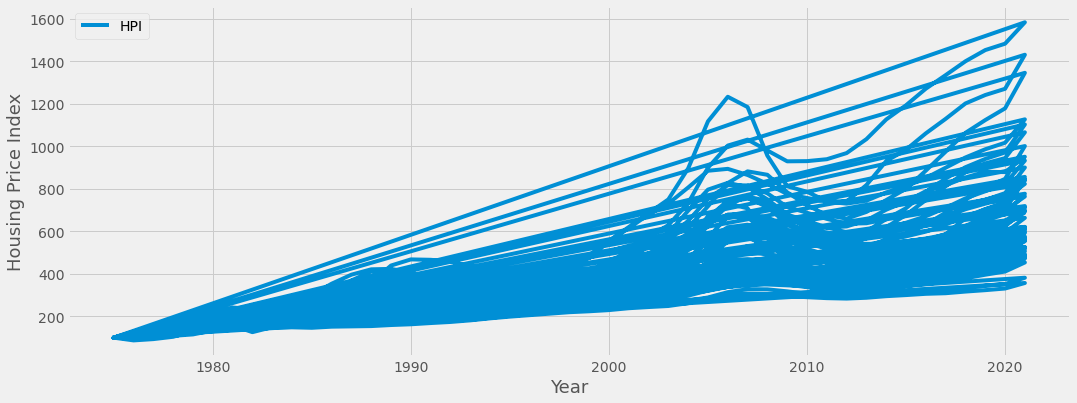

In [16]:
state_df.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("", fontsize = 18);


<div class="alert alert-block alert-info">
Nothing super surprising happening here. There are certainly states that appear to have lower rates of increase than others and definitely lower HPI than other states. We can see that our data is on an upward trend. We can also see that our data is non-stationary. For now let's continue exploring. 
</div>

### What states then have legalized recreational cannabis use? 
<br>

_According to the National Conference of State Legislatures, 21 states have legalized the adult use of marijuana for recreational purposes: Alaska, Arizona, California, Colorado, Connecticut, Illinois, Maine, Maryland, Massachusetts, Michigan, Missouri, Montana, New Jersey, New Mexico, New York, Nevada, Oregon, Rhode Island, Vermont, Virginia and Washington._  
<br>
From: https://www.cnet.com/news/politics/marijuana-laws-by-state-where-is-weed-legal/#:~:text=According%20to%20the%20National%20Conference,York%2C%20Nevada%2C%20Oregon%2C%20Rhode
<br>
For our purposes we will also need to know when each state legalized recreational use of cannabis by year. <br>

- Alaska: Q4 2014
- Arizona: Q4 2020
- California: Q4 2016
- Colorado: Q4 2012
- Connecticut: Q1 2023
- District of Columbia Q1 2014
- Illinois: Q1 2020
- Maine: Q4 2016
- Maryland: TBD (2023)
- Massachusetts: Q4 2016
- Michigan: Q4 2018
- Missouri: Q4 2022
- Montana: Q1 2021
- New Jersey: Q2 2022
- New Mexico: Q2 2021
- New York: Q1 2021
- Nevada: Q1 2017
- Oregon: Q3 2015
- Rhode Island: Q4 2022
- Vermont: Q4 2022
- Virginia: Q3 2021
- Washington: Q4 2012




## Time Series analysis of the HPI of states that have legalized recreational cannabis use

In [17]:
# Separate the states that have fully legalized recreational cannabis use to make time series data onb
Alaska = state_df[state_df['State'] == 'Alaska']
Arizona = state_df[state_df['State'] == 'Arizona']
California = state_df[state_df['State'] == 'California']
Colorado = state_df[state_df['State'] == 'Colorado']
Connecticut = state_df[state_df['State'] == 'Connecticut']
District_of_Columbia = state_df[state_df['State'] == 'District of Columbia']
Illinois = state_df[state_df['State'] == 'Illinois']
Maine = state_df[state_df['State'] == 'Maine']
Maryland = state_df[state_df['State'] == 'Maryland']
Massachusetts = state_df[state_df['State'] == 'Massachusetts']
Michigan = state_df[state_df['State'] == 'Michigan']
Missouri = state_df[state_df['State'] == 'Missouri']
Montana = state_df[state_df['State'] == 'Montana']
New_Jersey = state_df[state_df['State'] == 'New Jersey']
New_Mexico = state_df[state_df['State'] == 'New Mexico']
New_York = state_df[state_df['State'] == 'New York']
Nevada = state_df[state_df['State'] == 'Nevada']
Oregon = state_df[state_df['State'] == 'Oregon']
Rhode_Island = state_df[state_df['State'] == 'Rhode Island']
Vermont = state_df[state_df['State'] == 'Vermont']
Virginia = state_df[state_df['State'] == 'Virginia']
Washington = state_df[state_df['State'] == 'Washington']

### Analysis of results: Alaska
Considering that Alaska was one of the earliest adopters of recreational marijuana use it would be interesting to see if they were a trend setting state whether up or down. We should keep in mind that Alaska is a very remote location and is next to Canada, a country where _medicinal_ cannabis use has been legal since 2001.

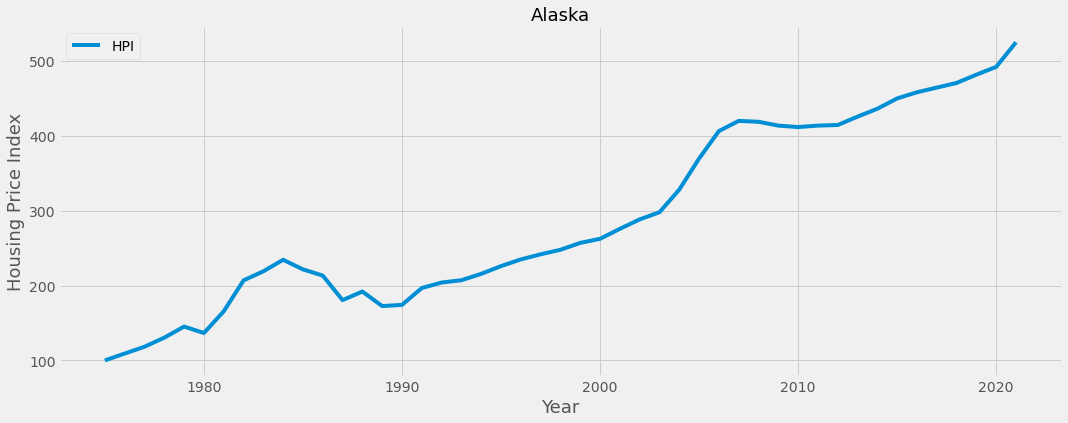

In [18]:
# Demo matplotlib on Alaska
Alaska.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("Alaska", fontsize = 18);


<div class="alert alert-block alert-info">
At surface level it would appear that there is little correlation to housing prices and cannabis legality. 
</div>

### Analyisis of results: California

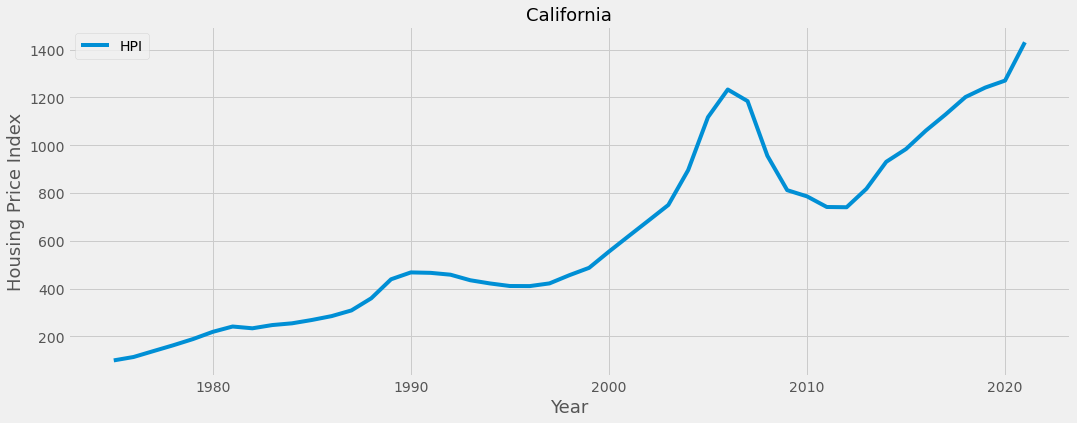

In [19]:
# Demo matplotlib on California
California.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("California", fontsize = 18);

<div class="alert alert-block alert-info">
Looking at the graph above it would appear the the 2008 housing market crash had a significant effect on housing prices in California, but also housing prices seem to have steadily risen since 2011/2012. 
</div>

## Dickey-Fuller Test: Alaska's HPI
Now, we probably already know that our data isn't stationary, but let's do a Dickey-Fuller test to make sure. 

In [20]:
# ak is the abbreviation for Alaska, let's use this to denote our data without consideration of state
ak = Alaska.drop(columns = 'State', axis =1)

In [21]:
# import adfuller from statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ak)
display(dftest)

(0.14462496949900688,
 0.9689790519636176,
 1,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 286.31163177676126)

In [22]:
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                  0.144625
p-value                         0.968979
#Lags Used                      1.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

In [23]:
ak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 1975 to 2021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HPI     47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [24]:
ak_diff = ak.diff(periods =1)

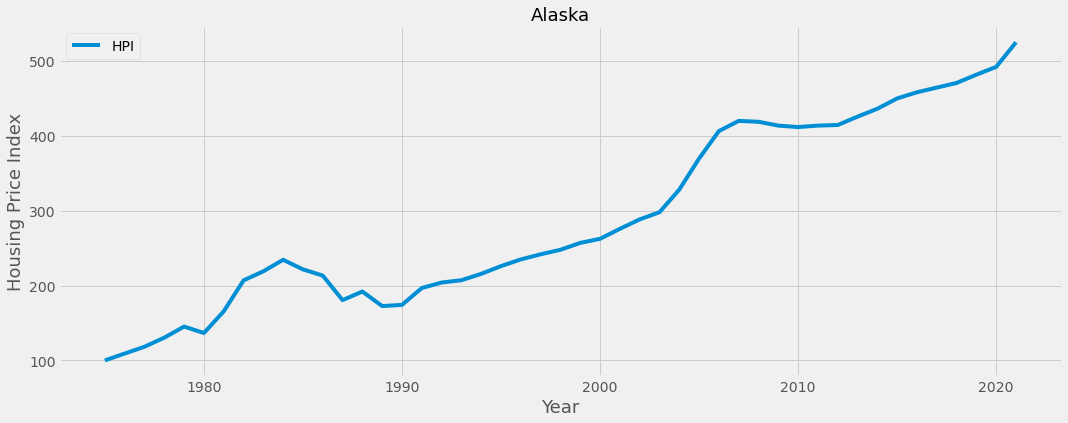

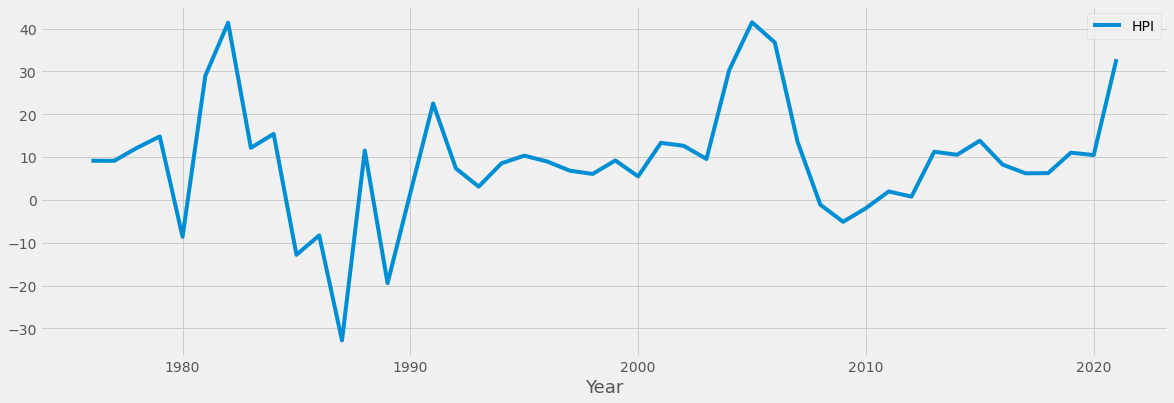

In [25]:
# Let's look at a comparison of the Alaska's housing market, naturally.
Alaska.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("Alaska", fontsize = 18);

# And another look with trends removed. 
ak_diff.plot(figsize = (18,6))
plt.xlabel('Year', fontsize = 18);

In [26]:
# Because we detrended with a period of 1 we will have lost one year/value
ak_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 1975 to 2021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HPI     46 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [27]:
# Drop null value(s) from our detrended information
ak_diff = ak_diff.dropna()

In [28]:
# Now that we have a detrended form of Alaska's HPI let's see what the 
# results of a new Dickey-Fuller test are
dftest = adfuller(ak_diff)
display(dftest)

dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
)

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

(-4.122311025463244,
 0.0008894715444660691,
 0,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 277.4017489871987)

Test Statistic                 -4.122311
p-value                         0.000889
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

<div class="alert alert-block alert-success">
Our p-value is < 0.05 and our Test Statistic is smaller than the 1% Critical Value; this means that statistically, we can reject the null hypothesis and consider our data stationary. 
</div>

### Function for differencing
Well that's great that we were able to walk through that process once. Let's make a function to lessen the amount of work we may have to do in the future for the remaining states. 

In [29]:
def diff (state):
    state = state.drop(columns = 'State', axis =1)
    state_diff = state.diff(periods =1)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(state_diff)

# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)


In [30]:
# The same function as above but meant for use on the national_df dataset
def national_diff (state):
    state = state.dropna()
    state_diff = state.diff(periods =1)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(state_diff)

# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

## Dickey-Fuller Test: California's HPI
Let's recreate the above test but with California's HPI and see if we can streamline the process a bit before doing the same to the rest of the states with legalized cannabis use. 

Test Statistic                 -4.172682
p-value                         0.000733
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

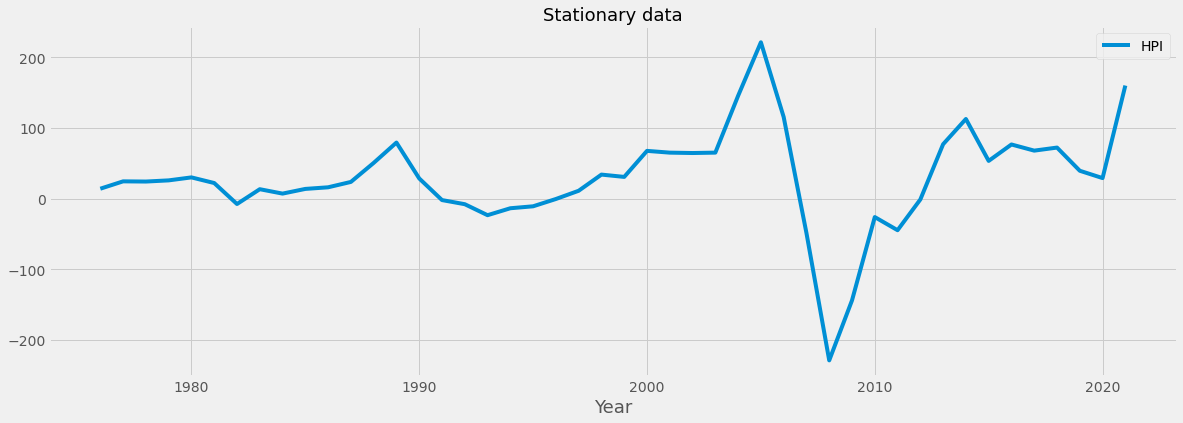

In [31]:
diff(California)

## Functions to create stationary data 

Below are the other functions that we will need to make our data stationary, if applicable

### Function for 2nd order differencing

In [32]:
def second_order_diff (state):
    state = state.drop(columns = 'State', axis =1)
    state_diff = state.diff(periods =2)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(state_diff)

# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)


### Function for 3rd order differencing 

In [33]:
def third_order_diff (state):
    state = state.drop(columns = 'State', axis =1)
    state_diff = state.diff(periods =3)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary data', fontsize = 18);
    dftest = adfuller(state_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)


In [34]:
def third_order_diff_1 (state):
    state = state.dropna()
    state_diff = state.diff(periods =3)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary data', fontsize = 18);
    dftest = adfuller(state_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

### Function for subtracting the rolling mean

In [35]:
def srm(state): 
    
    state = state.drop(columns = 'State')
    roll = state.rolling(window = 4).mean()
    
    # Subtract roll from our original data and create a new variable
    roll_minus = state - roll
    
    # Because we have a window = 4 we anticipate that there will be some nulls
    roll = roll_minus.dropna()

    # Plot HPI with trends removed
    roll.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary data', fontsize = 18);
    dftest = adfuller(roll)
    
# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

### Function for subtracting the exponential rolling mean

In [36]:
def erm(state): 

# Create the exp_roll_mean variable
    state = state.drop(columns = 'State')
    exp_roll_mean = state.ewm(halflife = 2).mean()

# Subtract exp_roll_mean from mi 
    minus_exp_roll_mean = state - exp_roll_mean

# Drop null values and for the love of god make it a shorter variable name
    mean = minus_exp_roll_mean.dropna()

# Plot state HPI with trends removed
    mean.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary Data', fontsize = 18);

    dftest = adfuller(mean)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

## Function to plot State information

In [37]:
def plot_states(states): 
    plot = states.drop(columns = 'State')

    plot.plot(figsize = (16,6))
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('HPI', fontsize = 18);

## Function to show state percentage HPI change over last 20 recorded years

In [38]:
def pct(state): 
    # create pct variable and change 'HPI' to a percentage
    pct = state['HPI'].pct_change()
    state = pd.DataFrame(state)
    state['pct'] = pct
    # print last 20 years 
    print(state.tail(20))

In [39]:
# Let's make another function for the final 5 years in the dataset to see if COVID had a profound effect on HPI
def pct_5(state): 
    pct = state['HPI'].pct_change()
    state = pd.DataFrame(state)
    state['pct'] = pct
    # Same as above but just the final 5, meant to be used for COVID analaysis
    print(state.tail(5))

In [40]:
# Perform the same function as the first but with no print out
def pct_np(state): 
    # create pct variable and change 'HPI' to a percentage
    
    state = pd.DataFrame(state)
    pct = state['HPI'].pct_change()
    state['pct'] = pct
#     Code below will not work to drop last record 
#     state.drop(index=state.index[-1], axis =0, inplace = True)

## Now let's do the rest of the states where recreational cannabis use is legal

<div class="alert alert-block alert-info">
In this section below we will only post the most statistically significant evidence that our data for each state is stationary. For all work shown there is a separate notebook titled 'all_work_shown' for testing of each method. 

</div>

### Arizona

Test Statistic                 -3.739708
p-value                         0.003588
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

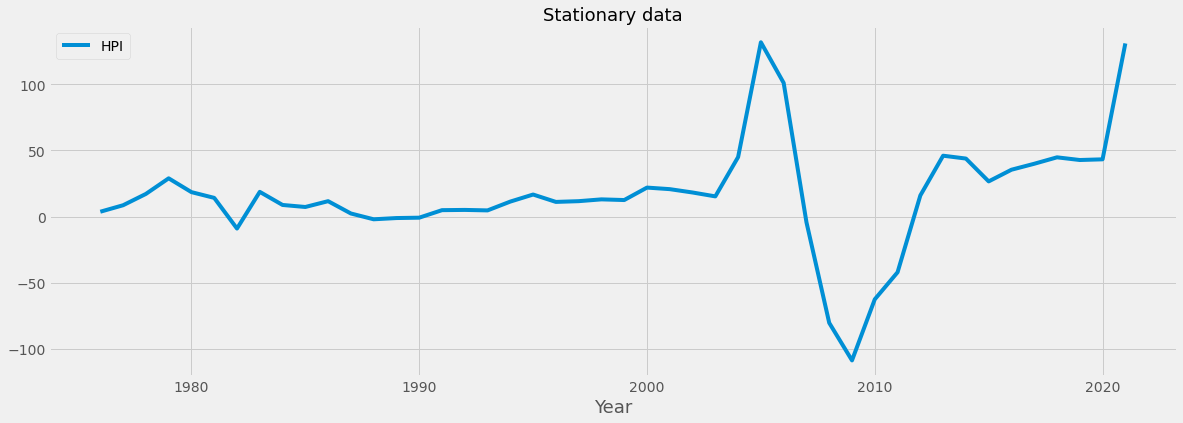

In [41]:
diff(Arizona)

### Colorado: N/A 

States where this is non-applicable have a good explanation shown in the next section

### Connecticut

Test Statistic                 -4.643123
p-value                         0.000107
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

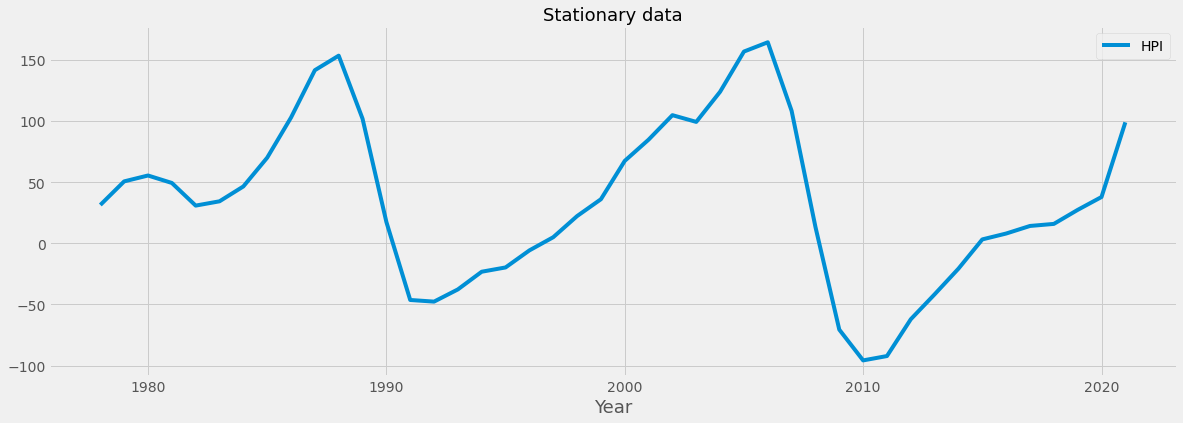

In [42]:
third_order_diff(Connecticut)

## District of Columbia

Test Statistic                 -3.363759
p-value                         0.012258
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

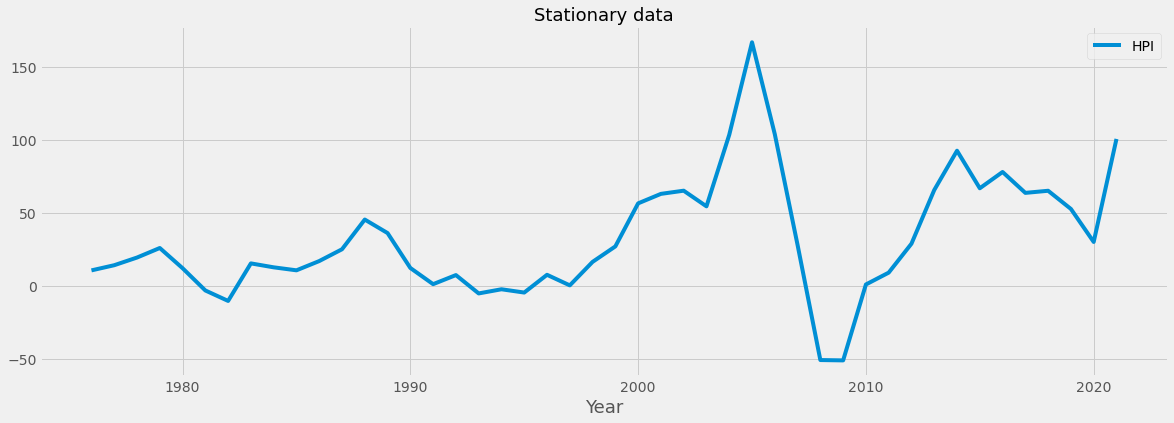

In [43]:
diff(District_of_Columbia)

### Illinois

Test Statistic                 -3.800120
p-value                         0.002906
#Lags Used                      1.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

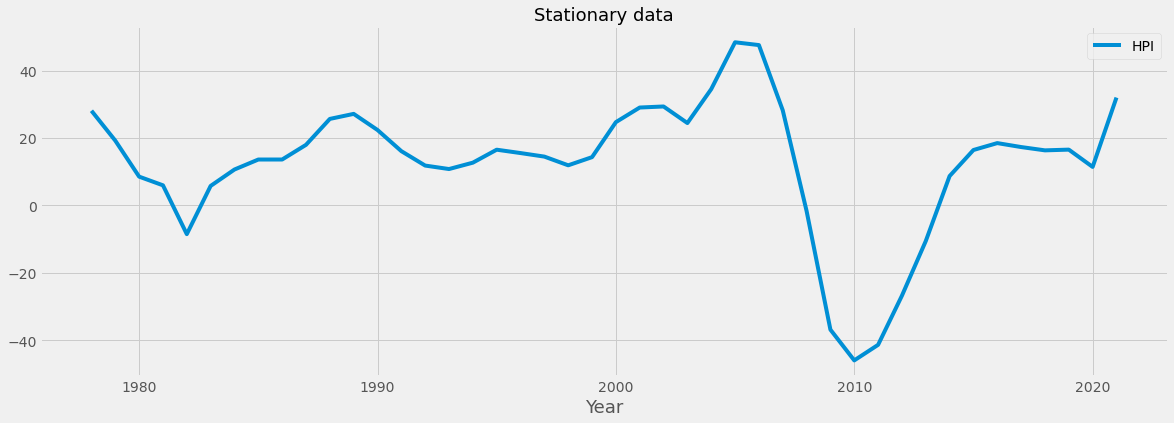

In [44]:
srm(Illinois)

### Maine

Test Statistic                 -3.729885
p-value                         0.003712
#Lags Used                     10.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

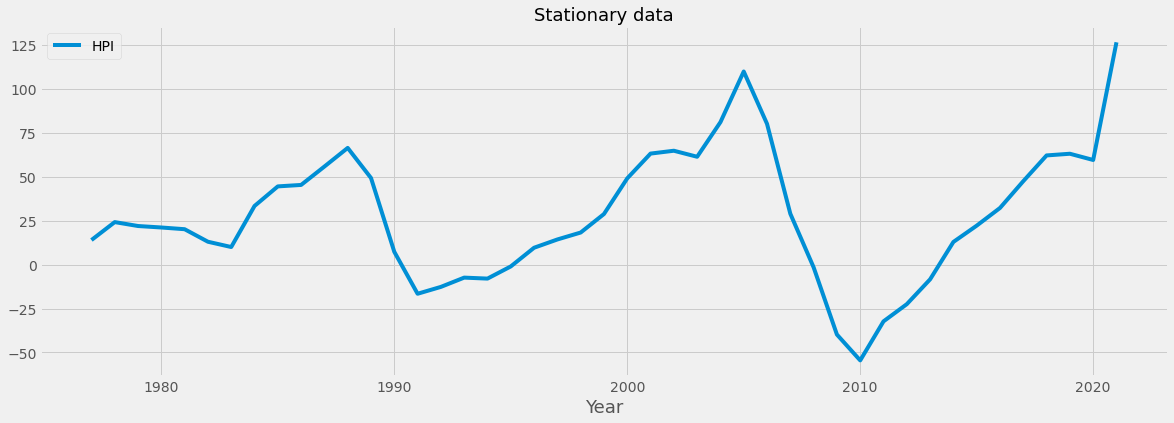

In [45]:
second_order_diff(Maine)

### Maryland

Test Statistic                 -4.742769
p-value                         0.000070
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

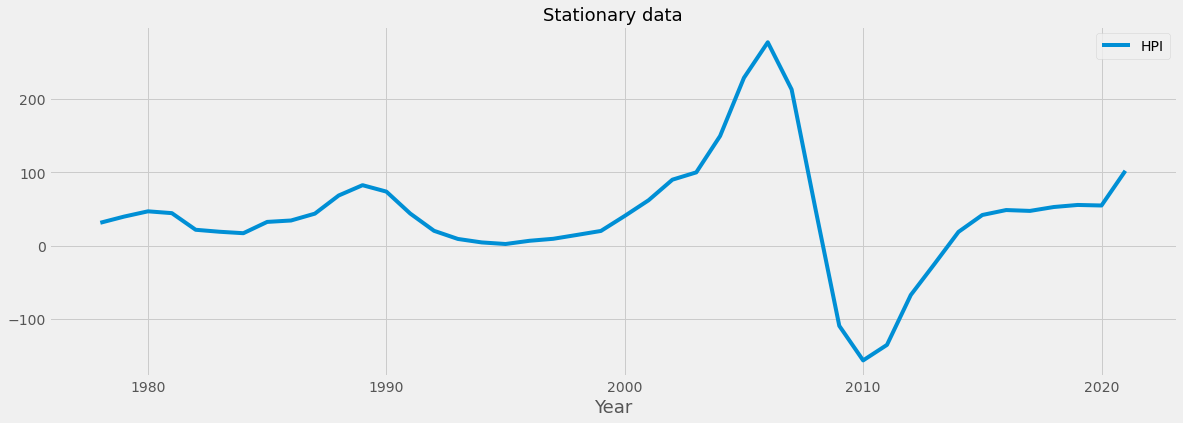

In [46]:
third_order_diff(Maryland)

### Massachusetts

Test Statistic                 -3.683313
p-value                         0.004354
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

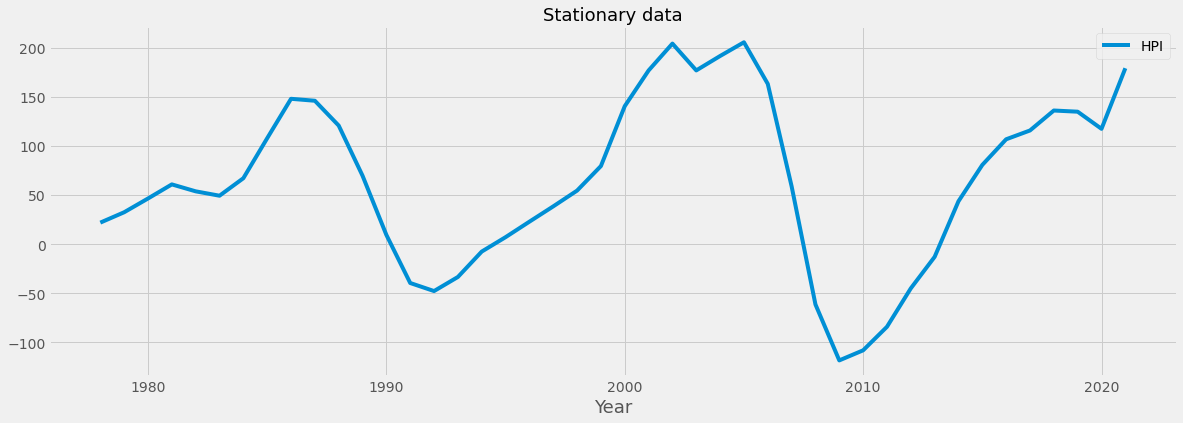

In [47]:
third_order_diff(Massachusetts)

### Michigan: between 95% - 99% statistical certainty

Test Statistic                 -3.125404
p-value                         0.024729
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

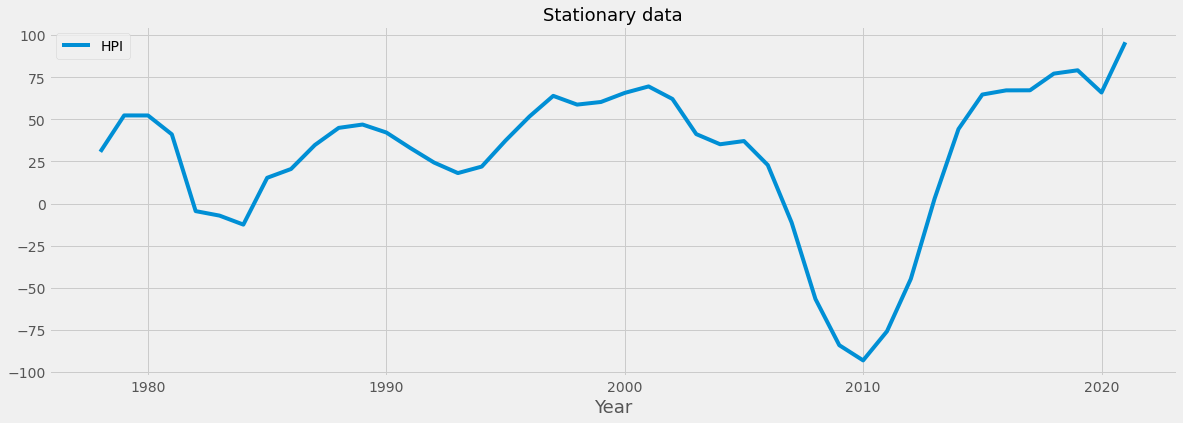

In [48]:
third_order_diff(Michigan)

### Missouri

Test Statistic                 -3.634356
p-value                         0.005137
#Lags Used                      9.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

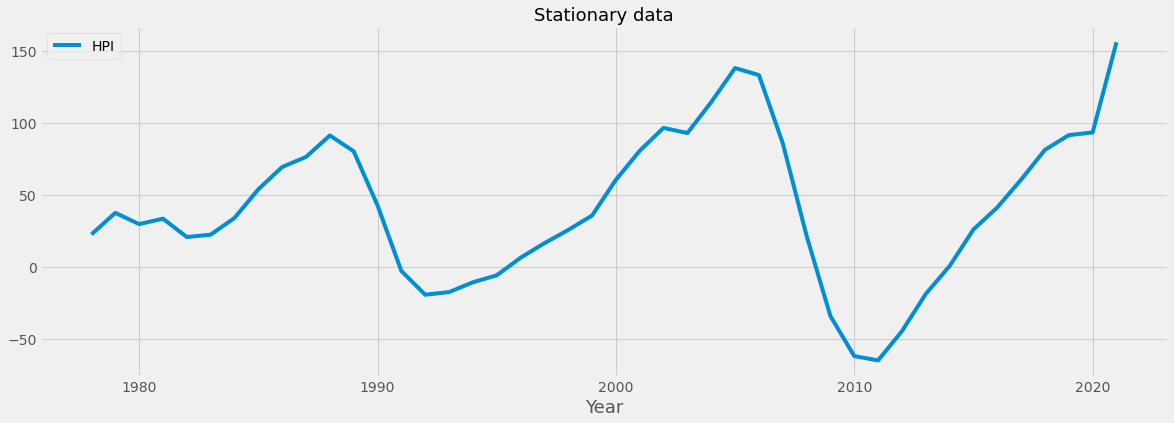

In [49]:
third_order_diff(Maine)

### Montana: N/A

### New Jersey

Test Statistic                 -5.431694
p-value                         0.000003
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

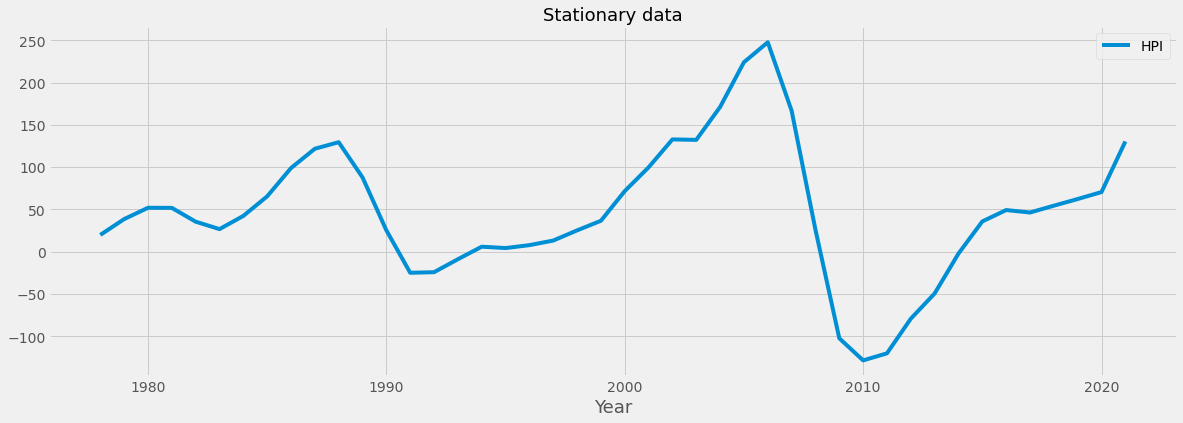

In [50]:
third_order_diff(New_Jersey)

### New Mexico

Test Statistic                 -3.586213
p-value                         0.006030
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

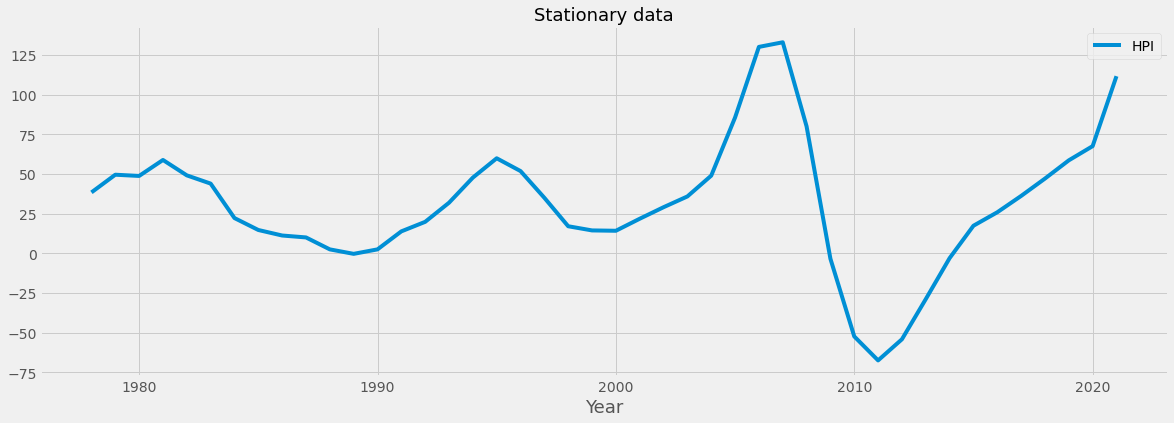

In [51]:
third_order_diff(New_Mexico)

### New York

Test Statistic                 -4.254506
p-value                         0.000532
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

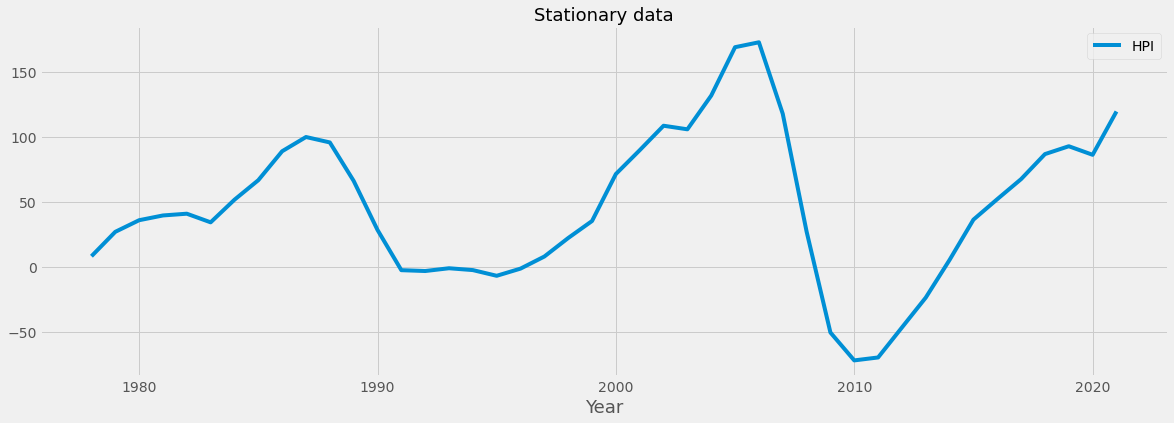

In [52]:
third_order_diff(New_York)

### Nevada

Test Statistic                 -4.044596
p-value                         0.001194
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

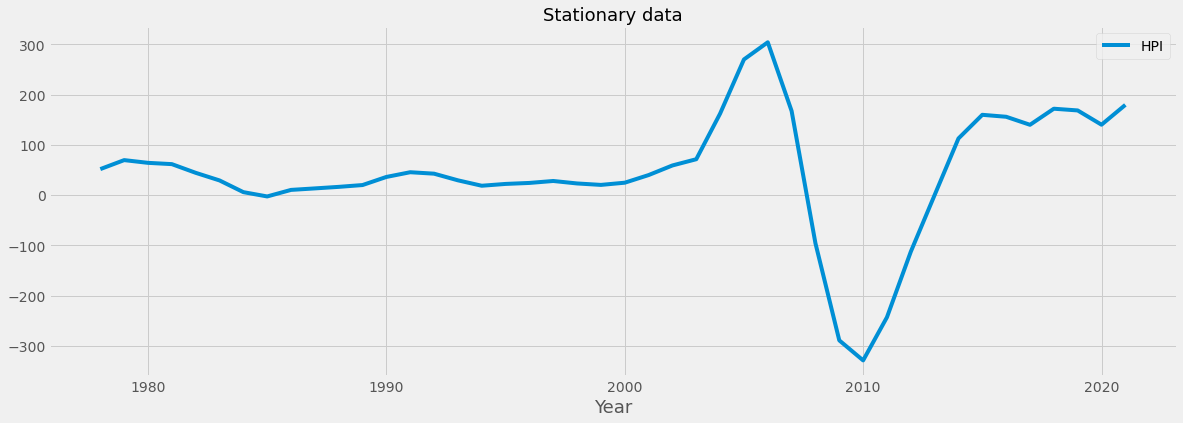

In [53]:
third_order_diff(Nevada)

### Oregon: N/A

### Rhode Island

Test Statistic                 -4.526884
p-value                         0.000176
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

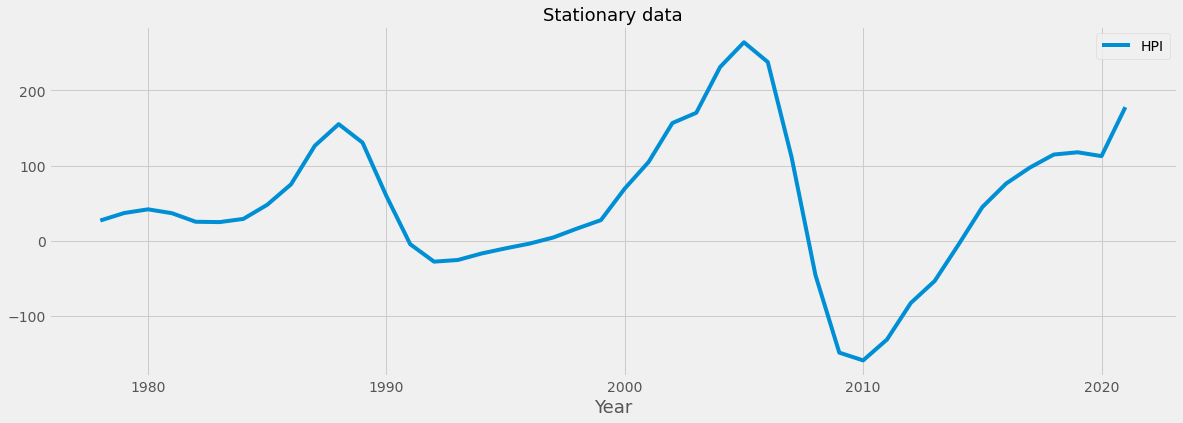

In [54]:
third_order_diff(Rhode_Island)

### Vermont

Test Statistic                 -3.550203
p-value                         0.006788
#Lags Used                     10.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

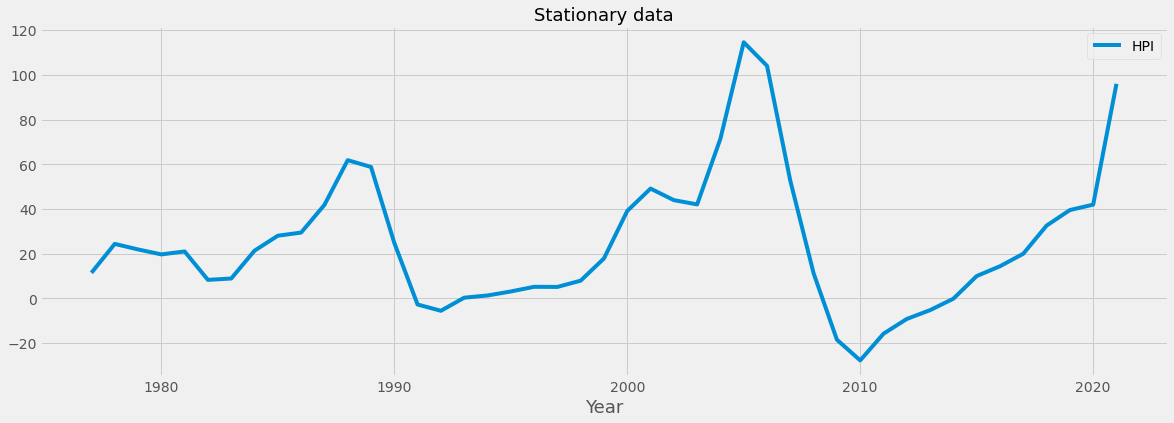

In [55]:
second_order_diff(Vermont)

### Virginia

Test Statistic                 -3.979741
p-value                         0.001520
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

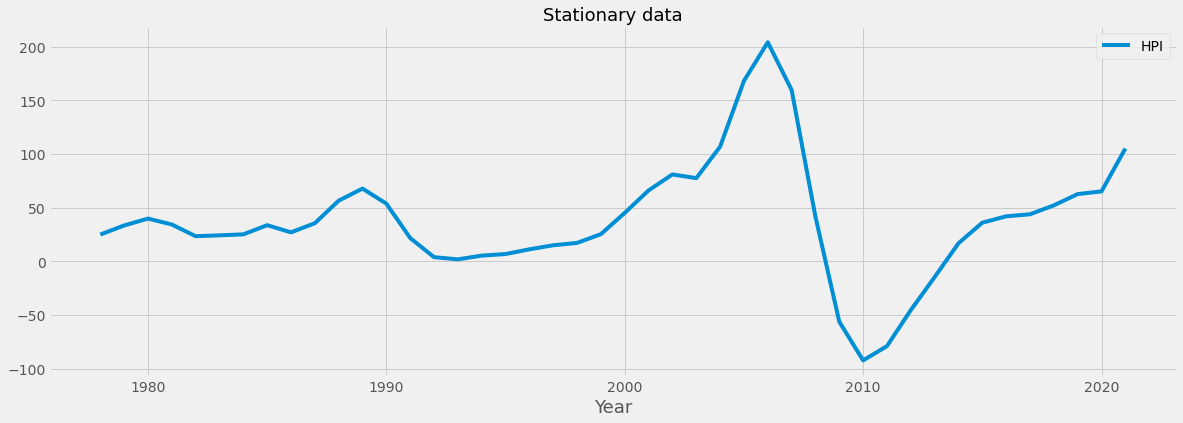

In [56]:
third_order_diff(Virginia)

### Washington: N/A

<div class="alert alert-block alert-danger">
Our endeavor to make all of the state HPI information stationary was only a halfway success. Listed below are the states that could not be considered stationary/mean and variance were not constant over time: <br> <br>
    Colorado<br>
    Oregon<br>
    Montana <br>
    Washington<br><br>
    We will address these states later in the notebook as well as any other states on the non-legal side to see if there is a reason that these states are considered non-stationary. 
</div>

## Training data and Testing Data

We will split our training data into 80% of the data, testing the following 20% but let's add in a TimeSeriesSplit down the road here. 

In [57]:
# We didn't make variable names for our stationary data, we should fix this
# in future versions
alaska_stationary = ak_diff

In [58]:
# Create our cutoff data for testing
cutoff = round(alaska_stationary.shape[0]*0.8)
cutoff

37

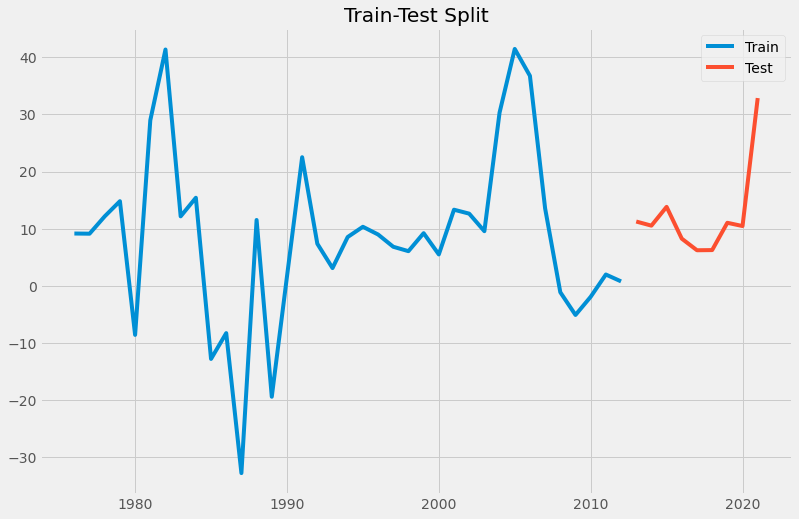

In [59]:
train = alaska_stationary[:cutoff]

test = alaska_stationary[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Train-Test Split')
plt.legend();

## ACF (Autocorrelation Function): Alaska

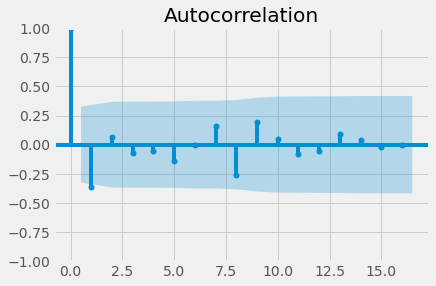

In [60]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train.diff().dropna());

For our Alaska data, 1, is our MA Term

## PACF 

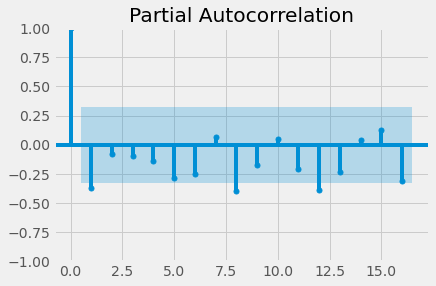

In [61]:
plot_pacf(train.diff().dropna());

It looks like the suggested AR value to be 1, also. 

## ARMA

In [62]:
# import ARIMA from statsmodels.tsa.arima.model
from statsmodels.tsa.arima.model import ARIMA
arma_alaska = ARIMA(train, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [63]:
print(arma_alaska.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   37
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -147.349
Date:                Tue, 25 Apr 2023   AIC                            300.698
Time:                        18:40:17   BIC                            305.449
Sample:                             0   HQIC                           302.356
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4295      0.164      2.616      0.009       0.108       0.751
ma.L1         -0.9997     32.971     -0.030      0.976     -65.622      63.623
sigma2       194.9018   6400.219      0.030      0.9

In [64]:
# Get our training score
print(arma_alaska.aic)

300.69805956522094


## Testing

In [65]:
# We will fit the same parameters on our testing score
arma_test = ARIMA(test, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [66]:
# Get our testing score
print(arma_test.aic)

62.3473085434561


In [67]:
# Get our RMSE score for this model
y_hat = arma_alaska.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat))

14.42700813473611

## TimeSeriesSplit()

In [68]:
# Import TimeSeriesSplit from sklearn.model_selection
from sklearn.model_selection import TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train): 
    print(train_ind, val_ind)

[0 1 2 3 4 5 6] [ 7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] [25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] [31 32 33 34 35 36]


## Cross-Validation 

Using the TimeSeriesSplit() we created earlier, we can cross-validate train-test splits to find the lowest RMSE before creating any new models. 

In [69]:
train.index

Int64Index([1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
            1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
            1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
            2009, 2010, 2011, 2012],
           dtype='int64', name='Year')

In [70]:
train_with_ind = train.reset_index()

In [71]:
# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error
# Code used from Greg Damico's lecture on example_modeling for time series data
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

32.70973866517336
13.401058338257245
2.218778494161175
21.59279066262728
23.49488882545559


According to the cross validation performed above we retain the best RMSE from the third cross validation, [2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24]

## Creating our best train/test split

In [72]:
train_with_ind.head()

,Year,HPI
0,1976,9.14
1,1977,9.11
2,1978,12.15
3,1979,14.80
4,1980,-8.61


In [73]:
train_1 = train[: 1994]
test_1 = test[:2000]

## ARMA model after cross validation

In [74]:
arma_alaska_1 = ARIMA(train_1, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [75]:
print(arma_alaska_1.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   37
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -147.349
Date:                Tue, 25 Apr 2023   AIC                            300.698
Time:                        18:40:19   BIC                            305.449
Sample:                             0   HQIC                           302.356
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4295      0.164      2.616      0.009       0.108       0.751
ma.L1         -0.9997     32.971     -0.030      0.976     -65.622      63.623
sigma2       194.9018   6400.219      0.030      0.9

Our AIC score has improved on our second model

In [76]:
arma_test_1 = ARIMA(test_1, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [77]:
print(arma_test_1.aic)

62.3473085434561


In [78]:
y_hat = arma_alaska_1.predict(typ='levels')
np.sqrt(mean_squared_error(train_1, y_hat))

14.42700813473611

It looks like our cross-validation suggests that a model trained on our time series split [2] would be the best performant with fewest errors but there seems to be a disconnect in how the model actually performs. 

## What is an AIC score? 

_AIC is defined as AIC=2×(log likelihood)+2×number of parameters_ <br>
(https://www.sciencedirect.com/topics/economics-econometrics-and-finance/akaike-information-criterion)<br><br>

AIC or Akaike Information Criterion is a measurement of "goodness of fit" a machine learning model may have on time series data. The closer to 0, the better. <br>

This implies that the criterion score is an ensemble score and that we are expected to take the model with the best performance but we have used ACF and PACF to inform us on how many AR terms and MA terms to use in our model. <br>

## What is the significance of our RMSE scores?

<br> Since we are looking to create the most accurate model and not necessarily the model with the best 'goodness of fit', we will prioritize RMSE scores over AIC scores. 

## What next? 

Let's take a look at the states that did legalize recreational cannabis use, when they did so, and if there was a higher bump in yearly HPI over the national average. 

In [79]:
# call on national_df
national_df.set_index('Year', inplace = True)
national_df.head()

,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
Year,,,,
1975,.,100.00,35.24,26.22
1976,5.55,105.55,37.19,27.67
1977,13.49,119.79,42.21,31.41
1978,14.88,137.61,48.49,36.08
1979,13.51,156.21,55.04,40.96


## ARMA model on our national_df dataset

In [80]:
national_arma = national_df.drop(columns = ['Annual Change (%)','HPI with 1990 base', 'HPI with 2000 base' ])

In [81]:
national_arma.head()

,HPI
Year,
1975,100.00
1976,105.55
1977,119.79
1978,137.61
1979,156.21


## Make our national data stationary

Test Statistic                 -5.194436
p-value                         0.000009
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

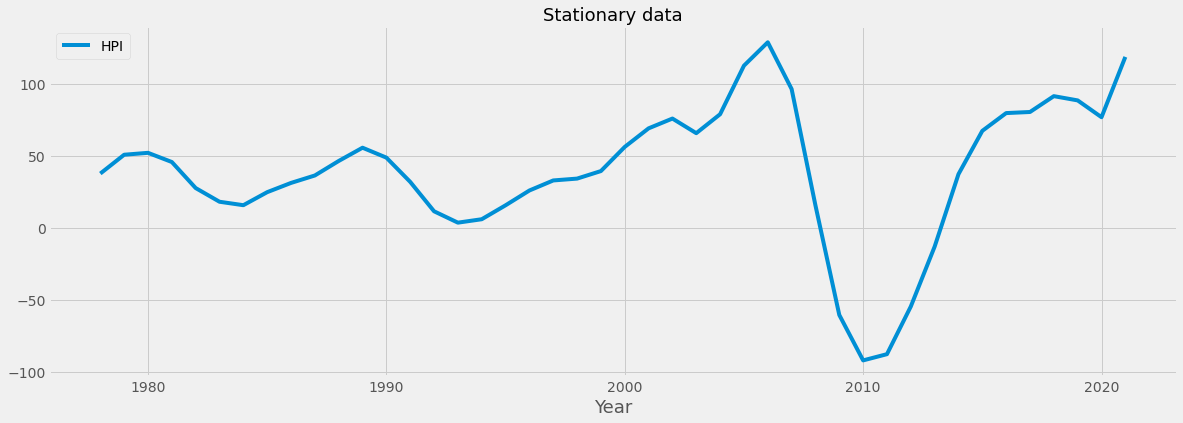

In [82]:
# Experiments run locally on same backbone of function: third_order_diff
national_stationary = third_order_diff_1(national_arma)
national_stationary

## Train/Test Split on national_arma

In [83]:
# Because we used a third_order_diff on our data, we will replicate this and create a new variable 
nat_arma = national_arma.diff(periods = 3)

In [84]:
# Create the desired cutoff for our train/test split
cutoff = round(nat_arma.shape[0] * 0.75)
cutoff

35

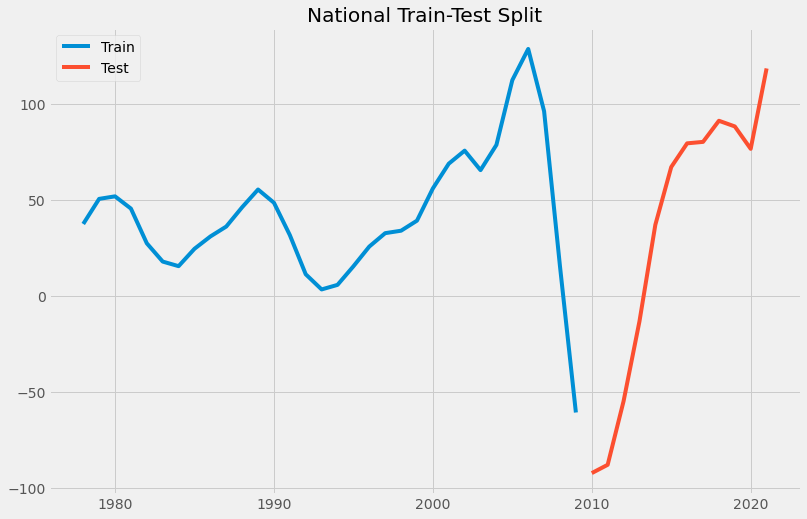

In [85]:
# Plot our new split plot
train = nat_arma[:cutoff]
test = nat_arma[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('National Train-Test Split')
plt.legend();

## Plot ACF on national data

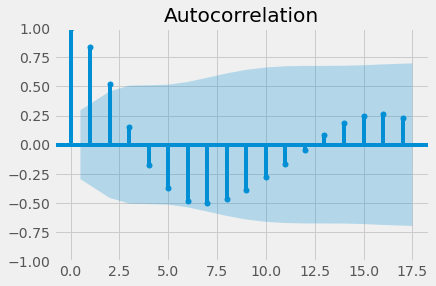

In [86]:
plot_acf(nat_arma.dropna());

2 will be our MA term

## Plot PACF on national data

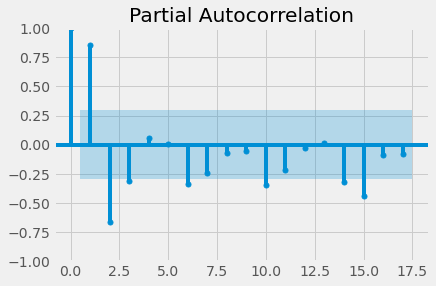

In [87]:
plot_pacf(nat_arma.dropna());

3 will be our AR term

## ARMA model on national dataset

In [88]:
arma_national = ARIMA(train, order = (3,0,2)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [89]:
print(arma_national.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   35
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -115.767
Date:                Tue, 25 Apr 2023   AIC                            245.535
Time:                        18:40:21   BIC                            256.422
Sample:                             0   HQIC                           249.293
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7197     19.286      1.852      0.064      -2.080      73.520
ar.L1          1.4580      0.182      8.022      0.000       1.102       1.814
ar.L2         -1.0006      0.330     -3.034      0.0

In [90]:
print(arma_national.aic)

245.53461901412504


## Testing on national dataset

In [91]:
# Create testing enviornment for national data 
arma_national_test = ARIMA(test, order = (3,0,2)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [92]:
# Get our aic testing score 
print(arma_national_test.aic)

121.77782826054778


In [93]:
train = train.fillna(method = 'backfill')

In [94]:
# Get our RMSE for this model 
y_hat = arma_national.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat))

7.903606181138747

## Predict into the future on national data

In [95]:
# fit our training model onto a new variable 'future' to get us an idea of 
# future forecast
forecast = arma_national.forecast(15)
forecast

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


35   -91.969491
36   -65.866179
37     0.489833
38    66.246886
39    99.761126
40    93.093585
41    60.011953
42    23.636912
43     2.673328
44     3.387758
45    19.777687
46    39.715322
47    52.494437
48    53.712125
49    45.785383
Name: predicted_mean, dtype: float64

Looks like we've got a small issue, our 'Year' column is not the index. Let's fix this. 

In [96]:
forecast.index.tolist()

[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

In [97]:
test.index.tolist()

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [98]:
forecast = pd.DataFrame(forecast)

In [99]:
forecast.tail()

,predicted_mean
45,19.777687
46,39.715322
47,52.494437
48,53.712125
49,45.785383


In [100]:
list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
        2019, 2020, 2021, 2022, 2023, 2024]

forecast['Year'] = list

forecast

,predicted_mean,Year
35,-91.969491,2010
36,-65.866179,2011
37,0.489833,2012
38,66.246886,2013
39,99.761126,2014
40,93.093585,2015
41,60.011953,2016
42,23.636912,2017
43,2.673328,2018
44,3.387758,2019


In [101]:
forecast = forecast.set_index('Year')

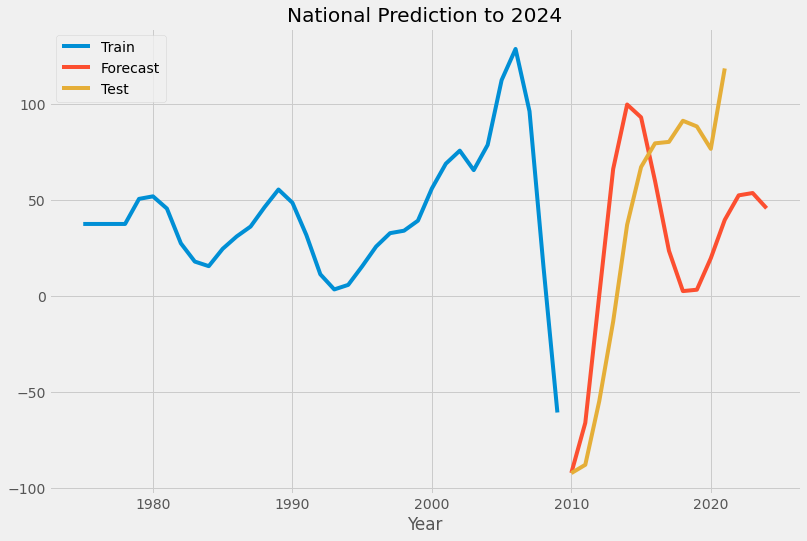

In [102]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('National Prediction to 2024')
ax.set_xlabel('Year')
ax.legend();

Our RMSE was 7.90, not bad considering we have values in the 100's in the training data. For our purposes this is an acceptable RMSE score. <br><br>
From here, we will look at the similarities and ddifferences that states that have legalized recreational cannabis use and those that have not. 

## Adding a DataFrame.pct_change

In [103]:
# Walkthrough of percentage function listed above in function section
Alaska_pct = Alaska['HPI'].pct_change()

In [104]:
national_tail = national_df.tail(10)

In [105]:
# Alaska legalized recreational cannabis in Q4 2014
print(Alaska_pct.tail(10))
print()
print(national_tail)

Year
2012    0.001837
2013    0.027112
2014    0.024705
2015    0.031650
2016    0.018305
2017    0.013547
2018    0.013431
2019    0.023405
2020    0.021687
2021    0.066747
Name: HPI, dtype: float64

     Annual Change (%)     HPI  HPI with 1990 base  HPI with 2000 base
Year                                                                  
2012             -1.69  460.58              162.29              120.76
2013              3.44  476.41              167.87              124.91
2014              6.14  505.69              178.19              132.58
2015              4.37  527.81              185.98              138.38
2016              5.34  555.97              195.91              145.77
2017              5.40  586.01              206.49              153.64
2018              5.65  619.12              218.16              162.33
2019              4.07  644.33              227.04              168.94
2020              2.85  662.71              233.52              173.75
2021             

If we look at the HPI in Alaska during 2015 and the HPI nationally in the 
same year it would appear that Alaska is below the average HPI nationally, 
but taking a look at the change in HPI for Alaska for the past 10 recorded years we see that the HPI percentage change was the second (first was 2021) highest for the state. 


## Predictions on states yet to legalize
Not all of the states that we are looking into are going to be useful but we can take a few things into account: location, historical HPI, and percentage changes during years after legalization. 

# Cannabis Legislation not yet passed
<br> 
States where cannabis legislation has not passed <br><br>

_All work shown below regarding states and stationary data is explored further in the work_shown notebook in the same repository_

In [106]:
Alabama = state_df[state_df['State'] == 'Alabama']
Arkansas = state_df[state_df['State'] == 'Arkansas']
Delaware = state_df[state_df['State'] == 'Delaware']
Florida = state_df[state_df['State'] == 'Florida']
Georgia = state_df[state_df['State'] == 'Georgia']
Hawaii = state_df[state_df['State'] == 'Hawaii']
Indiana = state_df[state_df['State'] == 'Indiana']
Iowa = state_df[state_df['State'] == 'Iowa']
Kentucky = state_df[state_df['State'] == 'Kentucky']
Louisiana = state_df[state_df['State'] == 'Louisiana']
Maryland = state_df[state_df['State'] == 'Maryland']
Minnesota = state_df[state_df['State'] == 'Minnesota']
Mississippi = state_df[state_df['State'] == 'Mississippi']
Nebraska = state_df[state_df['State'] == 'Nebraska']
New_Hampshire = state_df[state_df['State'] == 'New Hampshire']
North_Carolina = state_df[state_df['State'] == 'North Carolina']
North_Dakota = state_df[state_df['State'] == 'North Dakota']
Ohio = state_df[state_df['State'] == 'Ohio']
Oklahoma = state_df[state_df['State'] == 'Oklahoma']
Pennsylvania = state_df[state_df['State'] == 'Pennsylvania']
South_Carolina = state_df[state_df['State'] == 'South Carolina']
South_Dakota = state_df[state_df['State'] == 'South Dakota']
Tennessee = state_df[state_df['State'] == 'Tennessee']
Texas = state_df[state_df['State'] == 'Texas']
Utah = state_df[state_df['State'] == 'Utah']
West_Virginia = state_df[state_df['State'] == 'West Virginia']
Wisconsin = state_df[state_df['State'] == 'Wisconsin']
Wyoming = state_df[state_df['State'] == 'Wyoming']

## Does cannabis legality mean HPI is higher in that state? 

We can check this by looking at the previous twenty years of data on states that have not legalized recreational cannabis use. 

In [107]:
# Bring in our national_df dataframe for reference
national_df.tail(20)

,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
Year,,,,
2002,5.35,428.27,150.91,112.29
2003,4.38,447.03,157.52,117.21
2004,8.56,485.28,171.00,127.23
2005,11.42,540.72,190.53,141.77
2006,6.47,575.71,202.86,150.94
2007,1.01,581.53,204.91,152.47
2008,-4.35,556.21,195.99,145.83
2009,-7.37,515.21,181.54,135.08
2010,-4.99,489.50,172.49,128.34


On average, the states that have not legalized recreational cannabis use has a lower HPI than states that have legalized. 

## Alabama 
2002 HPI: 294.23 (134.05 under national average)<br>
2021 HPI: 453.77 (283.89 under national average)<br> 
Median age by state: 39 (taken from https://wisevoter.com/state-rankings/median-age-by-state/)

Test Statistic                 -3.916093
p-value                         0.001920
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

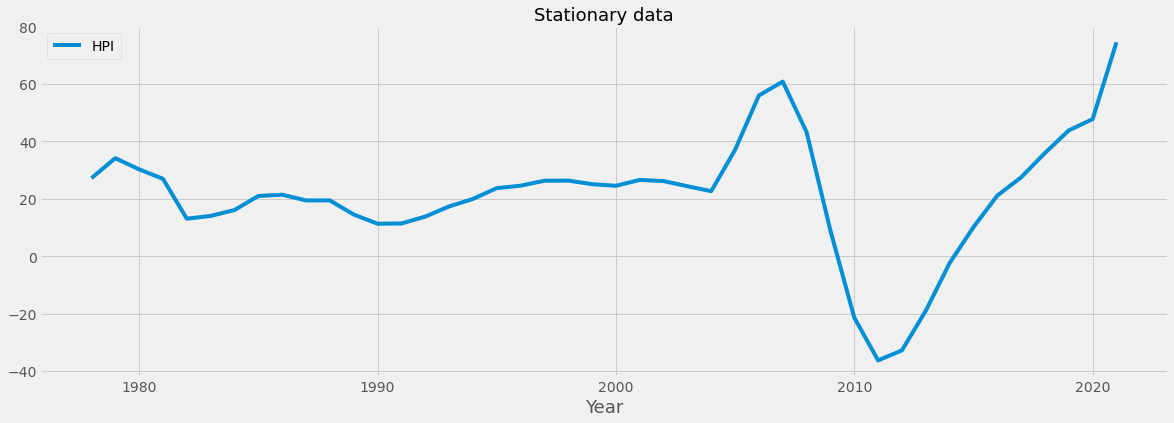

In [108]:
third_order_diff(Alabama)

In [109]:
pct(Alabama)

        State     HPI       pct
Year                           
2002  Alabama  294.23  0.021384
2003  Alabama  300.95  0.022839
2004  Alabama  310.72  0.032464
2005  Alabama  331.30  0.066233
2006  Alabama  356.99  0.077543
2007  Alabama  371.57  0.040841
2008  Alabama  374.56  0.008047
2009  Alabama  365.94 -0.023014
2010  Alabama  350.19 -0.043040
2011  Alabama  338.24 -0.034124
2012  Alabama  333.11 -0.015167
2013  Alabama  331.18 -0.005794
2014  Alabama  335.83  0.014041
2015  Alabama  343.23  0.022035
2016  Alabama  352.30  0.026425
2017  Alabama  363.31  0.031252
2018  Alabama  379.21  0.043764
2019  Alabama  396.15  0.044672
2020  Alabama  411.09  0.037713
2021  Alabama  453.77  0.103822


## Arkansas 
2002 HPI: 297.44 (130.83 under national average)<br>
2021 HPI: 472.36 (265.30 under national average)<br> 
Median age by state: 38 <br>
Non-stationary

In [110]:
pct(Arkansas)

         State     HPI       pct
Year                            
2002  Arkansas  297.44  0.026646
2003  Arkansas  305.18  0.026022
2004  Arkansas  321.95  0.054951
2005  Arkansas  344.62  0.070415
2006  Arkansas  364.77  0.058470
2007  Arkansas  373.61  0.024234
2008  Arkansas  371.90 -0.004577
2009  Arkansas  364.40 -0.020167
2010  Arkansas  354.03 -0.028458
2011  Arkansas  347.94 -0.017202
2012  Arkansas  347.54 -0.001150
2013  Arkansas  351.67  0.011884
2014  Arkansas  356.70  0.014303
2015  Arkansas  364.88  0.022932
2016  Arkansas  373.54  0.023734
2017  Arkansas  386.97  0.035953
2018  Arkansas  402.43  0.039951
2019  Arkansas  415.55  0.032602
2020  Arkansas  426.12  0.025436
2021  Arkansas  472.36  0.108514


## Delaware
2002 HPI: 374.30 (53.97 under national average)<br>
2021 HPI: 621.23 (116.43 under national average)<br> 
Median age by state: 41

Test Statistic                 -4.838370
p-value                         0.000046
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

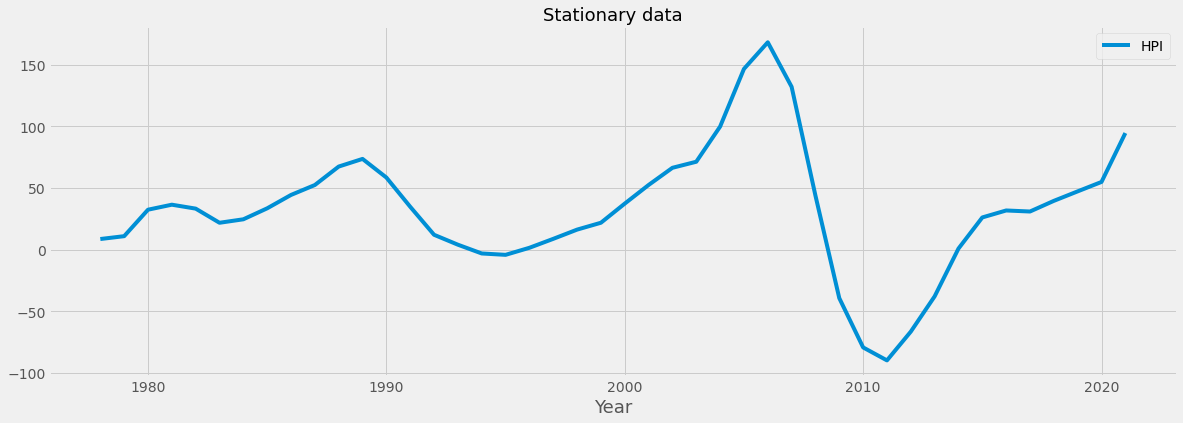

In [111]:
third_order_diff(Delaware)

In [112]:
pct(Delaware)

         State     HPI       pct
Year                            
2002  Delaware  374.30  0.069490
2003  Delaware  398.60  0.064921
2004  Delaware  449.85  0.128575
2005  Delaware  520.97  0.158097
2006  Delaware  566.90  0.088162
2007  Delaware  582.01  0.026654
2008  Delaware  564.77 -0.029621
2009  Delaware  527.50 -0.065991
2010  Delaware  502.61 -0.047185
2011  Delaware  474.84 -0.055252
2012  Delaware  460.93 -0.029294
2013  Delaware  464.67  0.008114
2014  Delaware  475.69  0.023716
2015  Delaware  487.05  0.023881
2016  Delaware  496.44  0.019279
2017  Delaware  506.62  0.020506
2018  Delaware  526.62  0.039477
2019  Delaware  543.72  0.032471
2020  Delaware  561.55  0.032793
2021  Delaware  621.23  0.106277


## Florida
2002 HPI: 333.52 (94.75 under national average)<br>
2021 HPI: 719.18 (18.48 under national average)<br> 
Median age by state: 42 <br>
between 95% - 99%

Test Statistic                 -3.635737
p-value                         0.005113
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

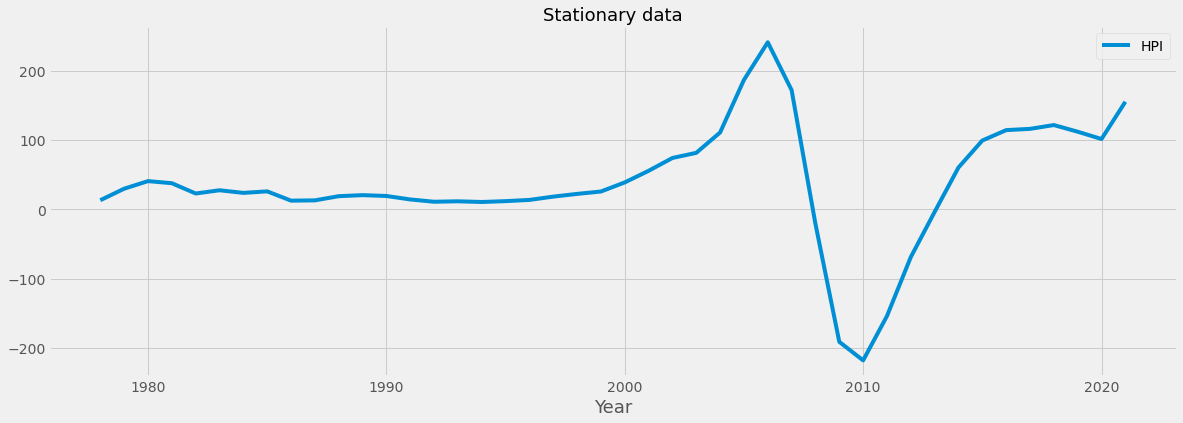

In [113]:
third_order_diff(Florida)

In [114]:
pct(Florida)

        State     HPI       pct
Year                           
2002  Florida  333.52  0.090505
2003  Florida  360.96  0.082274
2004  Florida  416.94  0.155086
2005  Florida  520.47  0.248309
2006  Florida  602.18  0.156993
2007  Florida  589.14 -0.021655
2008  Florida  499.59 -0.152001
2009  Florida  411.22 -0.176885
2010  Florida  371.38 -0.096882
2011  Florida  345.84 -0.068771
2012  Florida  342.53 -0.009571
2013  Florida  367.90  0.074067
2014  Florida  406.39  0.104621
2015  Florida  442.02  0.087674
2016  Florida  482.38  0.091308
2017  Florida  522.69  0.083565
2018  Florida  563.83  0.078708
2019  Florida  594.59  0.054555
2020  Florida  624.34  0.050034
2021  Florida  719.18  0.151904


## Georgia
2002 HPI: 334.67 (93.6 under national average)<br>
2021 HPI: 526.50 (211.16 under national average)<br> 
Median age by state: 37 

Test Statistic                -6.085449e+00
p-value                        1.067141e-07
#Lags Used                     1.000000e+01
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64

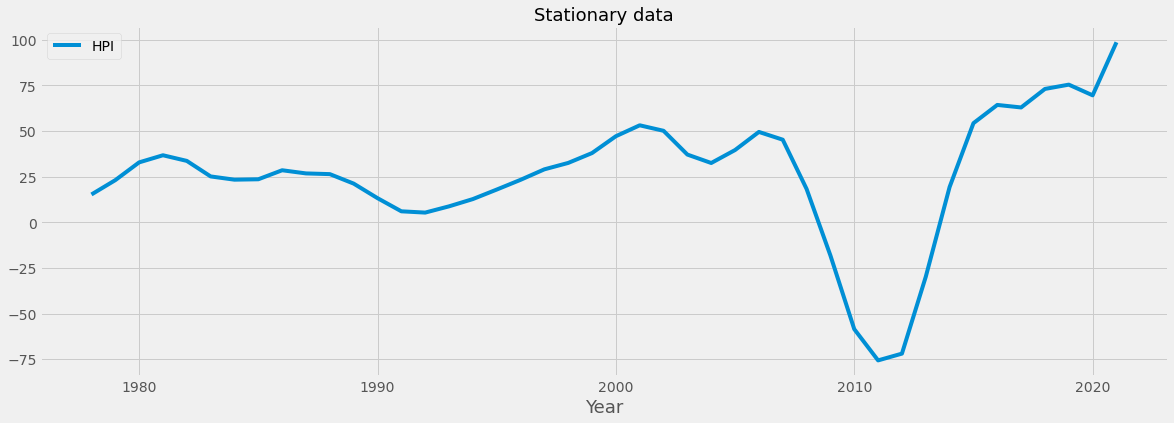

In [115]:
third_order_diff(Georgia)

In [116]:
pct(Georgia)

        State     HPI       pct
Year                           
2002  Georgia  334.67  0.036226
2003  Georgia  341.65  0.020856
2004  Georgia  355.37  0.040158
2005  Georgia  374.17  0.052903
2006  Georgia  391.06  0.045140
2007  Georgia  400.53  0.024216
2008  Georgia  392.37 -0.020373
2009  Georgia  372.82 -0.049825
2010  Georgia  341.98 -0.082721
2011  Georgia  316.70 -0.073922
2012  Georgia  300.86 -0.050016
2013  Georgia  312.10  0.037360
2014  Georgia  335.95  0.076418
2015  Georgia  355.06  0.056883
2016  Georgia  376.29  0.059793
2017  Georgia  398.76  0.059715
2018  Georgia  428.01  0.073352
2019  Georgia  451.59  0.055092
2020  Georgia  468.21  0.036803
2021  Georgia  526.50  0.124495


## Hawaii
2002 HPI: 394.91 (33.36 under national average)<br>
2021 HPI: 951.04 (213.38 above national average)<br> 
Median age by state: 39 

Test Statistic                 -5.298656
p-value                         0.000006
#Lags Used                      1.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64

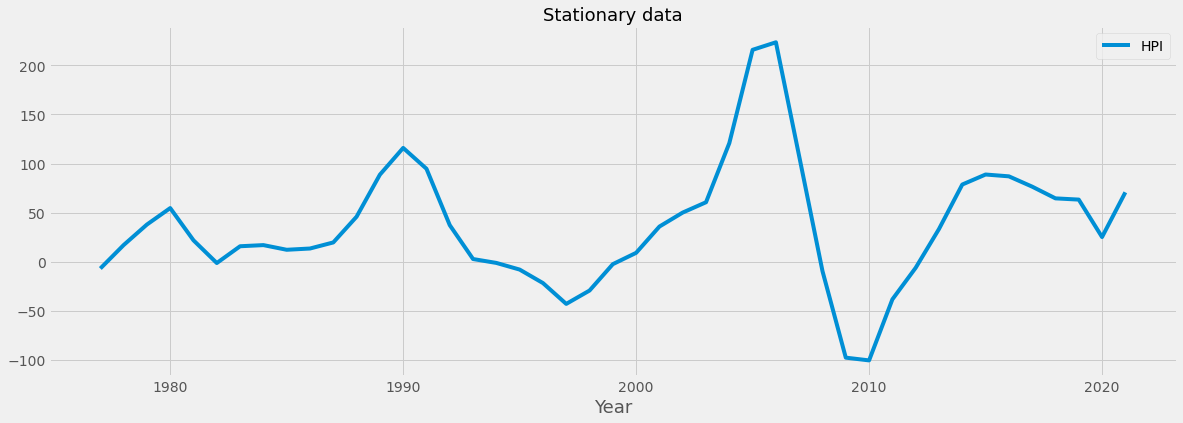

In [117]:
second_order_diff(Hawaii)

In [118]:
pct(Hawaii)

       State     HPI       pct
Year                          
2002  Hawaii  394.91  0.066978
2003  Hawaii  430.77  0.090805
2004  Hawaii  515.70  0.197159
2005  Hawaii  646.51  0.253655
2006  Hawaii  739.11  0.143231
2007  Hawaii  753.85  0.019943
2008  Hawaii  729.64 -0.032115
2009  Hawaii  656.36 -0.100433
2010  Hawaii  629.36 -0.041136
2011  Hawaii  618.18 -0.017764
2012  Hawaii  623.32  0.008315
2013  Hawaii  651.59  0.045354
2014  Hawaii  701.99  0.077349
2015  Hawaii  740.45  0.054787
2016  Hawaii  789.00  0.065568
2017  Hawaii  816.97  0.035450
2018  Hawaii  853.59  0.044824
2019  Hawaii  880.31  0.031303
2020  Hawaii  878.83 -0.001681
2021  Hawaii  951.04  0.082166


## Indiana 
2002 HPI: 341.69 (86.58 under national average)<br>
2021 HPI: 523.49 (214.17 under national average)<br> 
Median age by state: 38
Non-stationary

In [119]:
pct(Indiana)

        State     HPI       pct
Year                           
2002  Indiana  341.69  0.019483
2003  Indiana  346.29  0.013462
2004  Indiana  354.42  0.023477
2005  Indiana  366.65  0.034507
2006  Indiana  373.23  0.017946
2007  Indiana  377.39  0.011146
2008  Indiana  374.92 -0.006545
2009  Indiana  366.71 -0.021898
2010  Indiana  357.72 -0.024515
2011  Indiana  351.16 -0.018338
2012  Indiana  349.11 -0.005838
2013  Indiana  352.61  0.010025
2014  Indiana  361.02  0.023851
2015  Indiana  372.67  0.032270
2016  Indiana  385.67  0.034883
2017  Indiana  402.98  0.044883
2018  Indiana  429.20  0.065065
2019  Indiana  451.70  0.052423
2020  Indiana  468.79  0.037835
2021  Indiana  523.49  0.116683


## Iowa
2002 HPI: 315.67 (112.60 under national average)<br>
2021 HPI: 487.54 (250.12 under national average)<br> 
Median age by state: 38 <br>
Non-stationary

In [120]:
pct(Iowa)

     State     HPI       pct
Year                        
2002  Iowa  315.67  0.027873
2003  Iowa  322.92  0.022967
2004  Iowa  336.57  0.042271
2005  Iowa  352.53  0.047420
2006  Iowa  362.30  0.027714
2007  Iowa  368.78  0.017886
2008  Iowa  370.32  0.004176
2009  Iowa  368.42 -0.005131
2010  Iowa  364.64 -0.010260
2011  Iowa  362.53 -0.005787
2012  Iowa  364.18  0.004551
2013  Iowa  369.00  0.013235
2014  Iowa  377.72  0.023631
2015  Iowa  387.66  0.026316
2016  Iowa  400.93  0.034231
2017  Iowa  416.24  0.038186
2018  Iowa  431.49  0.036638
2019  Iowa  444.67  0.030545
2020  Iowa  451.85  0.016147
2021  Iowa  487.54  0.078986


## Kentucky
2002 HPI: 344.62 (83.65 under national average)<br>
2021 HPI: 553.66 (184 under national average)<br> 
Median age by state: 39 <br>
Non-stationary

In [121]:
pct(Kentucky)

         State     HPI       pct
Year                            
2002  Kentucky  344.62  0.025685
2003  Kentucky  352.86  0.023910
2004  Kentucky  367.86  0.042510
2005  Kentucky  386.55  0.050807
2006  Kentucky  399.14  0.032570
2007  Kentucky  407.15  0.020068
2008  Kentucky  409.14  0.004888
2009  Kentucky  403.03 -0.014934
2010  Kentucky  397.53 -0.013647
2011  Kentucky  391.53 -0.015093
2012  Kentucky  391.18 -0.000894
2013  Kentucky  393.41  0.005701
2014  Kentucky  400.16  0.017158
2015  Kentucky  411.86  0.029238
2016  Kentucky  427.56  0.038120
2017  Kentucky  447.86  0.047479
2018  Kentucky  467.59  0.044054
2019  Kentucky  486.23  0.039864
2020  Kentucky  502.95  0.034387
2021  Kentucky  553.66  0.100825


## Louisiana
2002 HPI: 312.68 (115.59 under national average)<br>
2021 HPI: 517.67 (219.99 under national average)<br> 
Median age by state: 37 

Test Statistic                 -4.014344
p-value                         0.001337
#Lags Used                      1.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

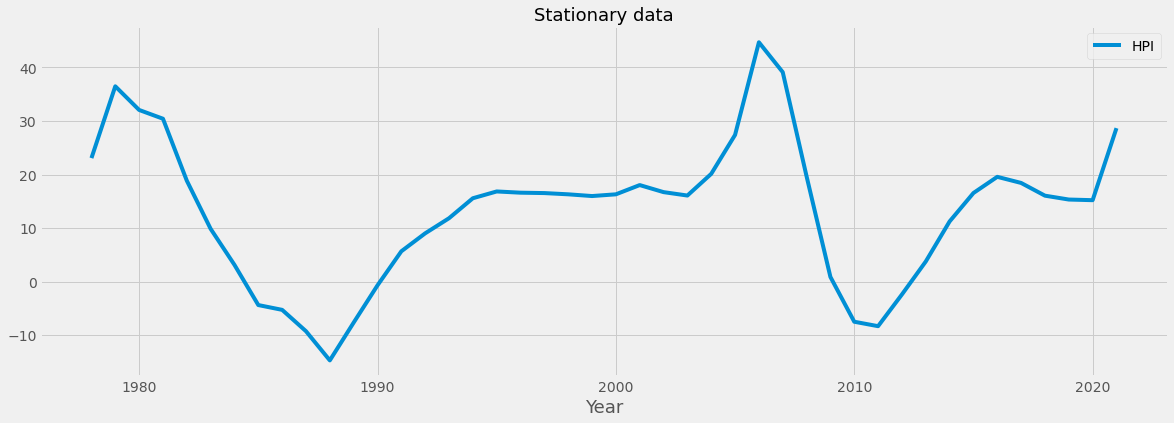

In [122]:
srm(Louisiana)

In [123]:
pct(Louisiana)

          State     HPI       pct
Year                             
2002  Louisiana  312.68  0.032424
2003  Louisiana  323.21  0.033677
2004  Louisiana  339.76  0.051205
2005  Louisiana  361.76  0.064752
2006  Louisiana  401.19  0.108995
2007  Louisiana  419.74  0.046237
2008  Louisiana  420.45  0.001692
2009  Louisiana  414.96 -0.013057
2010  Louisiana  408.39 -0.015833
2011  Louisiana  403.50 -0.011974
2012  Louisiana  405.75  0.005576
2013  Louisiana  410.89  0.012668
2014  Louisiana  421.70  0.026309
2015  Louisiana  434.85  0.031183
2016  Louisiana  448.58  0.031574
2017  Louisiana  459.62  0.024611
2018  Louisiana  469.09  0.020604
2019  Louisiana  479.54  0.022277
2020  Louisiana  489.70  0.021187
2021  Louisiana  517.67  0.057117


## Maryland
2002 HPI: 434.42 (6.15 above national average)<br>
2021 HPI: 764.20 (26.54 above national average)<br> 
Median age by state: 39 

Test Statistic                 -4.742769
p-value                         0.000070
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

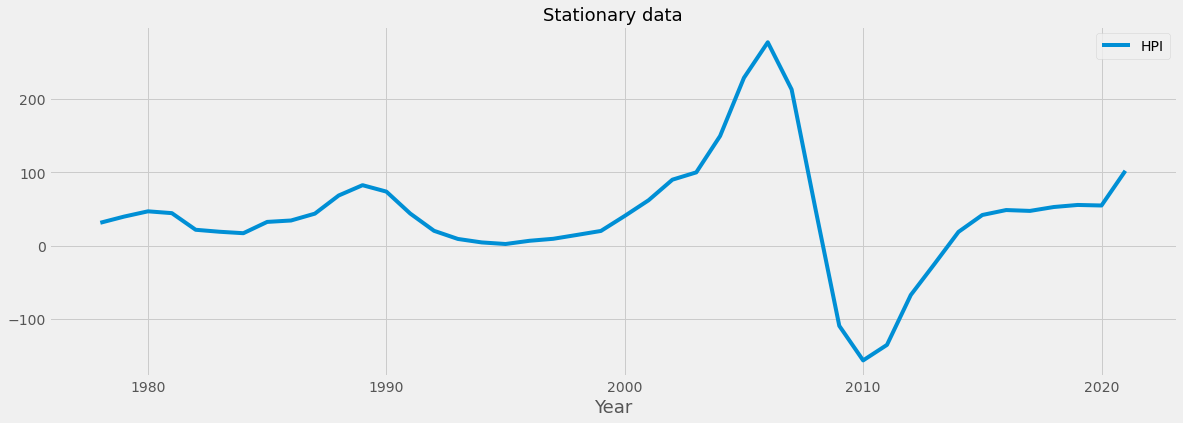

In [124]:
third_order_diff(Maryland)

In [125]:
pct(Maryland)

         State     HPI       pct
Year                            
2002  Maryland  434.42  0.096549
2003  Maryland  467.66  0.076516
2004  Maryland  545.74  0.166959
2005  Maryland  663.40  0.215597
2006  Maryland  745.18  0.123274
2007  Maryland  758.86  0.018358
2008  Maryland  713.45 -0.059840
2009  Maryland  635.50 -0.109258
2010  Maryland  601.98 -0.052746
2011  Maryland  577.76 -0.040234
2012  Maryland  567.94 -0.016997
2013  Maryland  577.11  0.016146
2014  Maryland  596.35  0.033339
2015  Maryland  609.62  0.022252
2016  Maryland  625.54  0.026115
2017  Maryland  643.61  0.028887
2018  Maryland  662.20  0.028884
2019  Maryland  680.92  0.028269
2020  Maryland  698.26  0.025466
2021  Maryland  764.20  0.094435


## Minnesota
2002 HPI: 453.55 (25.28 above national average)<br>
2021 HPI: 692.73 (44.93 under national average)<br> 
Median age by state: 38 <br>
between 95% - 99%

Test Statistic                 -3.342770
p-value                         0.013072
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

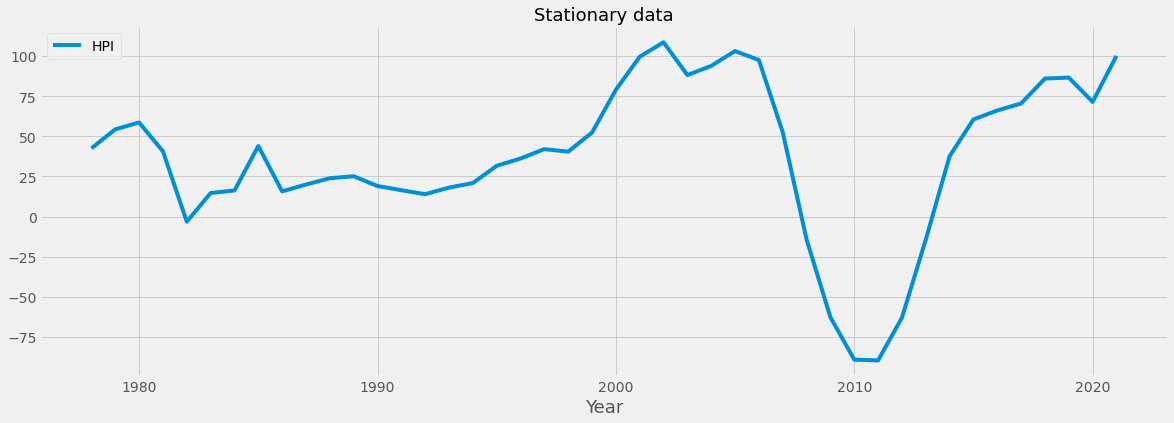

In [126]:
third_order_diff(Minnesota)

In [127]:
pct(Minnesota)

          State     HPI       pct
Year                             
2002  Minnesota  453.55  0.077290
2003  Minnesota  474.36  0.045882
2004  Minnesota  514.91  0.085484
2005  Minnesota  556.73  0.081218
2006  Minnesota  571.92  0.027284
2007  Minnesota  567.48 -0.007763
2008  Minnesota  542.43 -0.044143
2009  Minnesota  509.14 -0.061372
2010  Minnesota  478.27 -0.060632
2011  Minnesota  452.74 -0.053380
2012  Minnesota  446.03 -0.014821
2013  Minnesota  463.85  0.039952
2014  Minnesota  490.34  0.057109
2015  Minnesota  506.56  0.033079
2016  Minnesota  529.96  0.046194
2017  Minnesota  560.85  0.058287
2018  Minnesota  592.58  0.056575
2019  Minnesota  616.58  0.040501
2020  Minnesota  632.32  0.025528
2021  Minnesota  692.73  0.095537


## Mississippi
2002 HPI: 259.96 (168.31 under national average)<br>
2021 HPI: 381.90 (355.76 under national average)<br> 
Median age by state: 38<br>
between 95% - 99%

Test Statistic                 -3.591111
p-value                         0.005933
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

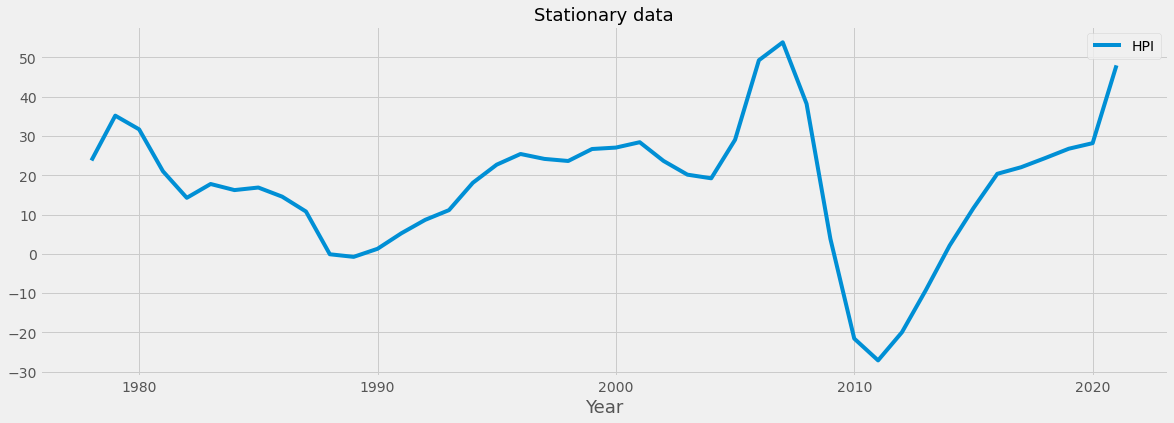

In [128]:
third_order_diff(Mississippi)

In [129]:
pct(Mississippi)

            State     HPI       pct
Year                               
2002  Mississippi  259.96  0.019851
2003  Mississippi  264.80  0.018618
2004  Mississippi  274.13  0.035234
2005  Mississippi  289.00  0.054244
2006  Mississippi  314.09  0.086817
2007  Mississippi  327.99  0.044255
2008  Mississippi  327.20 -0.002409
2009  Mississippi  317.89 -0.028454
2010  Mississippi  306.41 -0.036113
2011  Mississippi  300.07 -0.020691
2012  Mississippi  297.92 -0.007165
2013  Mississippi  297.14 -0.002618
2014  Mississippi  302.17  0.016928
2015  Mississippi  309.56  0.024456
2016  Mississippi  317.51  0.025682
2017  Mississippi  324.22  0.021133
2018  Mississippi  333.92  0.029918
2019  Mississippi  344.27  0.030995
2020  Mississippi  352.40  0.023615
2021  Mississippi  381.90  0.083712


## Nebraska
2002 HPI: 328.61 (99.66 below national average)<br>
2021 HPI: 562.70 (174.96 below national average)<br>
Median age by state: 37<br>
Non-Stationary

In [130]:
pct(Nebraska)

         State     HPI       pct
Year                            
2002  Nebraska  328.61  0.026041
2003  Nebraska  334.31  0.017346
2004  Nebraska  349.16  0.044420
2005  Nebraska  364.82  0.044850
2006  Nebraska  371.83  0.019215
2007  Nebraska  375.89  0.010919
2008  Nebraska  373.97 -0.005108
2009  Nebraska  371.20 -0.007407
2010  Nebraska  367.84 -0.009052
2011  Nebraska  366.08 -0.004785
2012  Nebraska  368.37  0.006255
2013  Nebraska  377.01  0.023455
2014  Nebraska  391.33  0.037983
2015  Nebraska  406.63  0.039097
2016  Nebraska  423.69  0.041955
2017  Nebraska  448.10  0.057613
2018  Nebraska  471.24  0.051640
2019  Nebraska  495.22  0.050887
2020  Nebraska  509.47  0.028775
2021  Nebraska  562.70  0.104481


## New Hampshire
2002 HPI: 497.21 (68.94 above national average)<br>
2021 HPI: 842.52 (104.86 above national average)<br> 
Median age by state: 43 <br>
between 95% - 99%

Test Statistic                 -3.615564
p-value                         0.005470
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

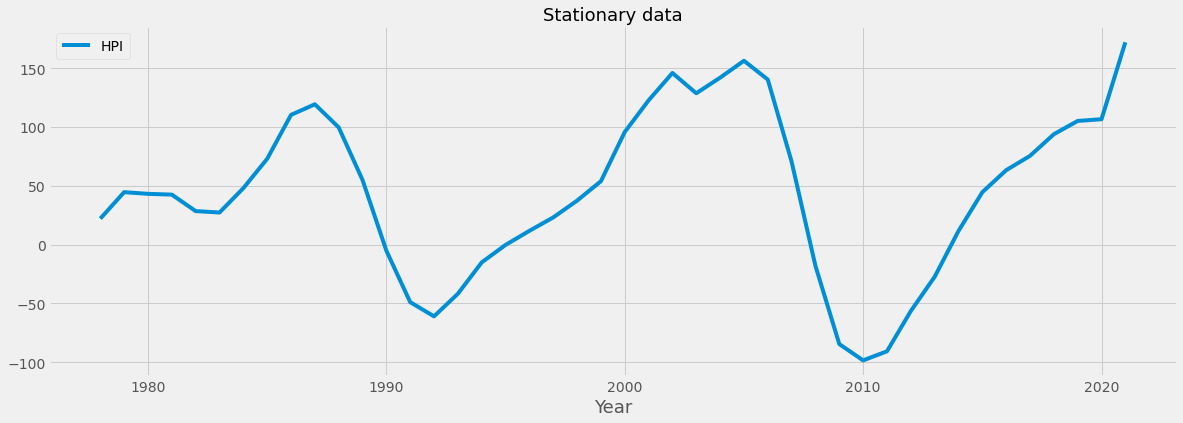

In [131]:
third_order_diff(New_Hampshire)

In [132]:
pct(New_Hampshire)

              State     HPI       pct
Year                                 
2002  New Hampshire  497.21  0.107989
2003  New Hampshire  532.29  0.070554
2004  New Hampshire  590.83  0.109978
2005  New Hampshire  653.68  0.106376
2006  New Hampshire  672.80  0.029250
2007  New Hampshire  661.42 -0.016914
2008  New Hampshire  635.63 -0.038992
2009  New Hampshire  588.23 -0.074572
2010  New Hampshire  562.96 -0.042959
2011  New Hampshire  544.91 -0.032063
2012  New Hampshire  531.74 -0.024169
2013  New Hampshire  535.61  0.007278
2014  New Hampshire  556.55  0.039096
2015  New Hampshire  576.37  0.035612
2016  New Hampshire  598.96  0.039194
2017  New Hampshire  632.09  0.055313
2018  New Hampshire  670.33  0.060498
2019  New Hampshire  704.23  0.050572
2020  New Hampshire  738.83  0.049132
2021  New Hampshire  842.52  0.140344


## North Carolina
2002 HPI: 352.81 (75.46 national average)<br>
2021 HPI: 592.45 (145.21 below national average)<br>
Median age by state: 39

Test Statistic                 -5.388258
p-value                         0.000004
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

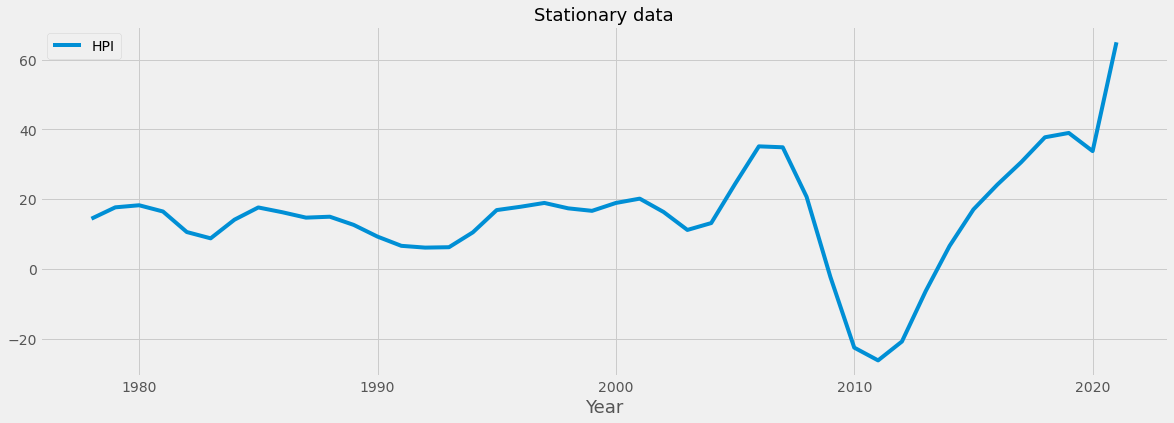

In [133]:
srm(North_Carolina)

In [134]:
pct(North_Carolina)

               State     HPI       pct
Year                                  
2002  North Carolina  352.81  0.022697
2003  North Carolina  357.94  0.014540
2004  North Carolina  369.43  0.032100
2005  North Carolina  392.52  0.062502
2006  North Carolina  420.12  0.070315
2007  North Carolina  440.49  0.048486
2008  North Carolina  445.27  0.010852
2009  North Carolina  432.20 -0.029353
2010  North Carolina  409.25 -0.053100
2011  North Carolina  393.96 -0.037361
2012  North Carolina  384.07 -0.025104
2013  North Carolina  387.33  0.008488
2014  North Carolina  397.25  0.025611
2015  North Carolina  412.27  0.037810
2016  North Carolina  431.12  0.045722
2017  North Carolina  454.29  0.053744
2018  North Carolina  482.85  0.062867
2019  North Carolina  508.03  0.052149
2020  North Carolina  526.73  0.036809
2021  North Carolina  592.45  0.124770


## North Dakota
2002 HPI: 269.90 (158.37 under national average)<br>
2021 HPI: 564.90 (281.01 under national average)<br> 
Median age by state: 35 <br>
Non-stationary

In [135]:
pct(North_Dakota)

             State     HPI       pct
Year                                
2002  North Dakota  269.90  0.039596
2003  North Dakota  279.27  0.034717
2004  North Dakota  297.49  0.065242
2005  North Dakota  321.80  0.081717
2006  North Dakota  342.16  0.063269
2007  North Dakota  357.52  0.044891
2008  North Dakota  366.50  0.025117
2009  North Dakota  370.29  0.010341
2010  North Dakota  375.20  0.013260
2011  North Dakota  387.24  0.032090
2012  North Dakota  407.67  0.052758
2013  North Dakota  442.01  0.084235
2014  North Dakota  476.28  0.077532
2015  North Dakota  497.49  0.044533
2016  North Dakota  509.18  0.023498
2017  North Dakota  515.11  0.011646
2018  North Dakota  522.07  0.013512
2019  North Dakota  533.75  0.022372
2020  North Dakota  539.02  0.009874
2021  North Dakota  564.90  0.048013


## Ohio 
2002 HPI: 342.82 (85.45 under national average)<br>
2021 HPI: 478.06 (259.60 under national average)<br> 
Median age by state: 40 <br>
between 95% - 99%

Test Statistic                 -3.285624
p-value                         0.015533
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

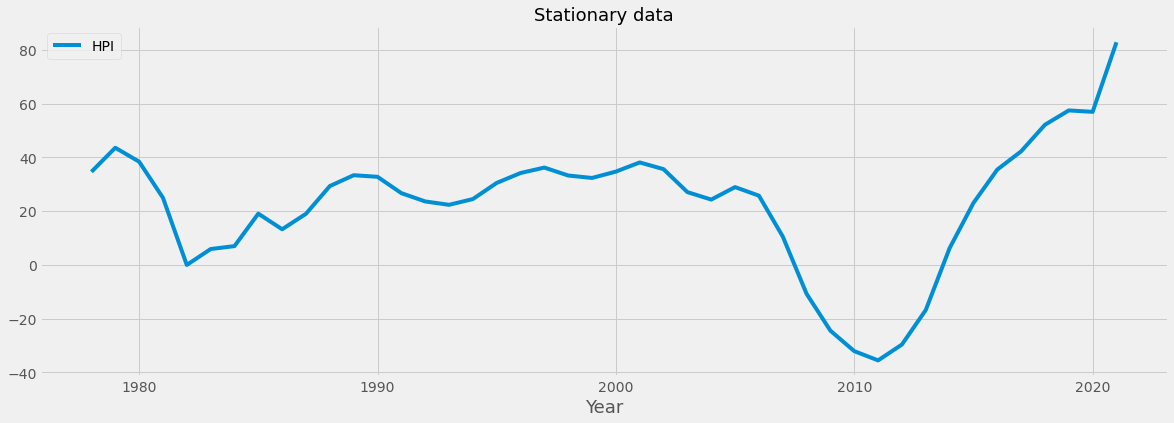

In [136]:
third_order_diff(Ohio)

In [137]:
pct(Ohio)

     State     HPI       pct
Year                        
2002  Ohio  342.82  0.023313
2003  Ohio  348.48  0.016510
2004  Ohio  359.30  0.031049
2005  Ohio  371.76  0.034679
2006  Ohio  374.23  0.006644
2007  Ohio  369.86 -0.011677
2008  Ohio  360.96 -0.024063
2009  Ohio  349.70 -0.031195
2010  Ohio  337.72 -0.034258
2011  Ohio  325.37 -0.036569
2012  Ohio  320.02 -0.016443
2013  Ohio  320.89  0.002719
2014  Ohio  331.58  0.033314
2015  Ohio  343.05  0.034592
2016  Ohio  356.35  0.038770
2017  Ohio  373.83  0.049053
2018  Ohio  395.20  0.057165
2019  Ohio  413.84  0.047166
2020  Ohio  430.79  0.040958
2021  Ohio  478.06  0.109729


## Oklahoma 
2002 HPI: 289.01 (139.26 under national average)<br>
2021 HPI: 492.28 (245.38 under national average)<br> 
Median age by state: 37<br>
N/A

In [138]:
pct(Oklahoma)

         State     HPI       pct
Year                            
2002  Oklahoma  289.01  0.033323
2003  Oklahoma  297.28  0.028615
2004  Oklahoma  308.86  0.038953
2005  Oklahoma  324.09  0.049310
2006  Oklahoma  338.90  0.045697
2007  Oklahoma  352.04  0.038772
2008  Oklahoma  358.18  0.017441
2009  Oklahoma  357.66 -0.001452
2010  Oklahoma  355.38 -0.006375
2011  Oklahoma  349.61 -0.016236
2012  Oklahoma  352.77  0.009039
2013  Oklahoma  358.66  0.016696
2014  Oklahoma  370.02  0.031673
2015  Oklahoma  383.15  0.035485
2016  Oklahoma  392.29  0.023855
2017  Oklahoma  405.60  0.033929
2018  Oklahoma  417.43  0.029167
2019  Oklahoma  432.78  0.036773
2020  Oklahoma  448.33  0.035930
2021  Oklahoma  492.28  0.098030


## Pennsylvania 
2002 HPI: 354.54 (73.73 under national average)<br>
2021 HPI: 611.76 (125.90 under national average)<br> 
Median age by state: 41 

Test Statistic                 -4.744417
p-value                         0.000069
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

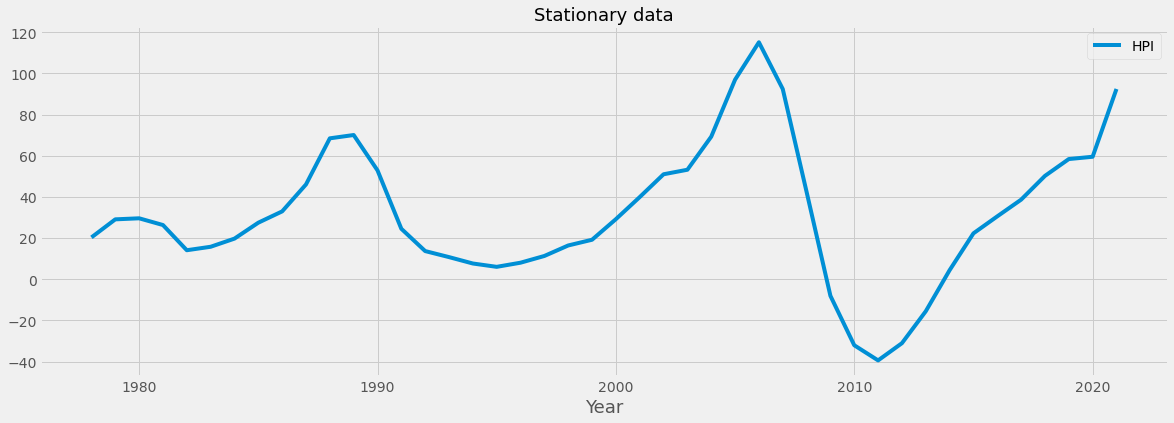

In [139]:
third_order_diff(Pennsylvania)

In [140]:
pct(Pennsylvania)

             State     HPI       pct
Year                                
2002  Pennsylvania  354.54  0.055022
2003  Pennsylvania  370.68  0.045524
2004  Pennsylvania  405.34  0.093504
2005  Pennsylvania  451.51  0.113904
2006  Pennsylvania  485.82  0.075989
2007  Pennsylvania  497.79  0.024639
2008  Pennsylvania  494.00 -0.007614
2009  Pennsylvania  477.79 -0.032814
2010  Pennsylvania  465.75 -0.025199
2011  Pennsylvania  454.60 -0.023940
2012  Pennsylvania  446.75 -0.017268
2013  Pennsylvania  450.22  0.007767
2014  Pennsylvania  459.02  0.019546
2015  Pennsylvania  469.07  0.021894
2016  Pennsylvania  480.80  0.025007
2017  Pennsylvania  497.71  0.035171
2018  Pennsylvania  519.30  0.043379
2019  Pennsylvania  539.21  0.038340
2020  Pennsylvania  557.24  0.033438
2021  Pennsylvania  611.76  0.097839


## South Carolina
2002 HPI: 332.00 (96.27 below national average)<br>
2021 HPI: 556.93 (180.73 below national average)<br>
Median age by state: 40

Test Statistic                 -4.063552
p-value                         0.001112
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

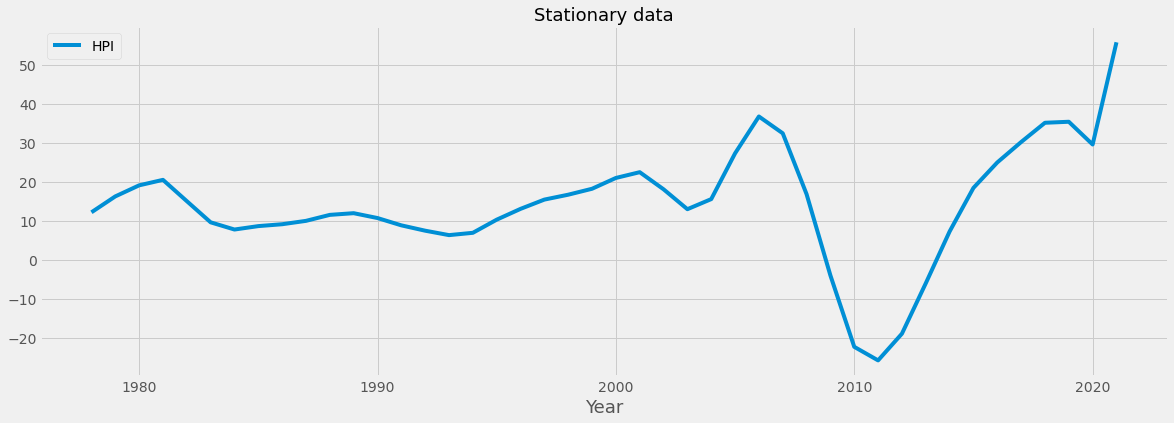

In [141]:
srm(South_Carolina)

In [142]:
pct(South_Carolina)

               State     HPI       pct
Year                                  
2002  South Carolina  332.00  0.026974
2003  South Carolina  338.39  0.019247
2004  South Carolina  351.98  0.040161
2005  South Carolina  377.19  0.071623
2006  South Carolina  404.86  0.073358
2007  South Carolina  421.27  0.040533
2008  South Carolina  423.55  0.005412
2009  South Carolina  411.21 -0.029135
2010  South Carolina  388.92 -0.054206
2011  South Carolina  373.50 -0.039648
2012  South Carolina  365.95 -0.020214
2013  South Carolina  368.09  0.005848
2014  South Carolina  378.86  0.029259
2015  South Carolina  395.56  0.044080
2016  South Carolina  414.13  0.046946
2017  South Carolina  436.45  0.053896
2018  South Carolina  462.24  0.059090
2019  South Carolina  484.81  0.048827
2020  South Carolina  500.60  0.032569
2021  South Carolina  556.93  0.112525


## South Dakota
2002 HPI: 321.66 (106.61 under national average)<br>
2021 HPI: 613.98 (123.68 under national average)<br> 
Median age by state: 37<br>
between 95% - 99%

Test Statistic                 -3.005495
p-value                         0.034384
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

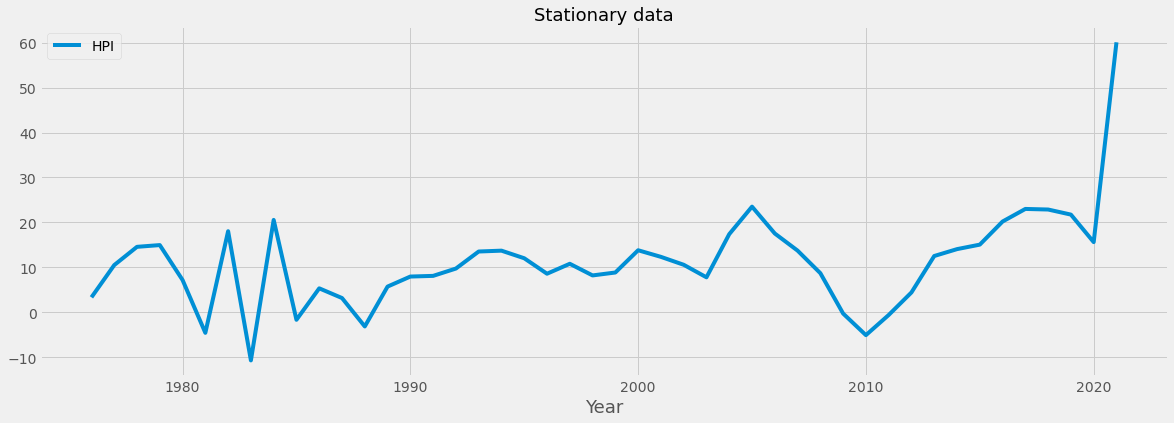

In [143]:
diff(South_Dakota)

In [144]:
pct(South_Dakota)

             State     HPI       pct
Year                                
2002  South Dakota  321.66  0.034011
2003  South Dakota  329.45  0.024218
2004  South Dakota  346.84  0.052785
2005  South Dakota  370.35  0.067783
2006  South Dakota  387.89  0.047361
2007  South Dakota  401.62  0.035397
2008  South Dakota  410.33  0.021687
2009  South Dakota  410.06 -0.000658
2010  South Dakota  404.99 -0.012364
2011  South Dakota  404.40 -0.001457
2012  South Dakota  408.83  0.010955
2013  South Dakota  421.36  0.030648
2014  South Dakota  435.42  0.033368
2015  South Dakota  450.48  0.034587
2016  South Dakota  470.68  0.044841
2017  South Dakota  493.68  0.048865
2018  South Dakota  516.55  0.046326
2019  South Dakota  538.29  0.042087
2020  South Dakota  553.91  0.029018
2021  South Dakota  613.98  0.108447


## Tennessee
2002 HPI: 320.12 (108.15 under national average)<br>
2021 HPI: 601.36 (136.30 under national average)<br> 
Median age by state: 39 <br>
Non-stationary

In [145]:
pct(Tennessee)

          State     HPI       pct
Year                             
2002  Tennessee  320.12  0.022519
2003  Tennessee  325.69  0.017400
2004  Tennessee  337.39  0.035924
2005  Tennessee  358.86  0.063636
2006  Tennessee  384.27  0.070808
2007  Tennessee  399.75  0.040284
2008  Tennessee  400.37  0.001551
2009  Tennessee  390.62 -0.024352
2010  Tennessee  376.93 -0.035047
2011  Tennessee  366.95 -0.026477
2012  Tennessee  363.17 -0.010301
2013  Tennessee  368.74  0.015337
2014  Tennessee  384.00  0.041384
2015  Tennessee  400.43  0.042786
2016  Tennessee  422.62  0.055415
2017  Tennessee  451.98  0.069471
2018  Tennessee  483.22  0.069118
2019  Tennessee  509.45  0.054282
2020  Tennessee  529.85  0.040043
2021  Tennessee  601.36  0.134963


## Texas 
2002 HPI: 294.59 (133.68 under national average)<br>
2021 HPI: 612.54 (125.12 under national average)<br> 
Median age by state: N/A <br> 
Non-stationary

In [146]:
pct(Texas)

      State     HPI       pct
Year                         
2002  Texas  294.59  0.030648
2003  Texas  300.46  0.019926
2004  Texas  306.97  0.021667
2005  Texas  320.40  0.043750
2006  Texas  338.72  0.057179
2007  Texas  354.60  0.046882
2008  Texas  359.52  0.013875
2009  Texas  358.00 -0.004228
2010  Texas  352.97 -0.014050
2011  Texas  348.20 -0.013514
2012  Texas  351.26  0.008788
2013  Texas  365.69  0.041081
2014  Texas  393.28  0.075446
2015  Texas  419.39  0.066390
2016  Texas  448.32  0.068981
2017  Texas  479.66  0.069905
2018  Texas  508.04  0.059167
2019  Texas  530.81  0.044819
2020  Texas  546.27  0.029125
2021  Texas  612.54  0.121314


## Utah
2002 HPI: 421.61 (6.66 under national average)<br>
2021 HPI: 1001.31 (263.65 above national average)<br> 
Median age by state: 31<br>
Non-stationary

In [147]:
pct(Utah)

     State      HPI       pct
Year                         
2002  Utah   421.61  0.008130
2003  Utah   423.19  0.003748
2004  Utah   434.70  0.027198
2005  Utah   477.02  0.097354
2006  Utah   551.66  0.156471
2007  Utah   615.39  0.115524
2008  Utah   611.89 -0.005687
2009  Utah   559.62 -0.085424
2010  Utah   517.82 -0.074694
2011  Utah   489.86 -0.053996
2012  Utah   494.20  0.008860
2013  Utah   526.18  0.064711
2014  Utah   562.01  0.068095
2015  Utah   588.43  0.047010
2016  Utah   632.34  0.074622
2017  Utah   687.83  0.087753
2018  Utah   749.38  0.089484
2019  Utah   804.67  0.073781
2020  Utah   847.05  0.052668
2021  Utah  1001.31  0.182114


## West Virginia
2002 HPI: 244.03 (184.24 under national average)<br>
2021 HPI: 357.19 (380.47 under national average)<br> 
Median age by state: 43

Test Statistic                 -4.327741
p-value                         0.000398
#Lags Used                      3.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64

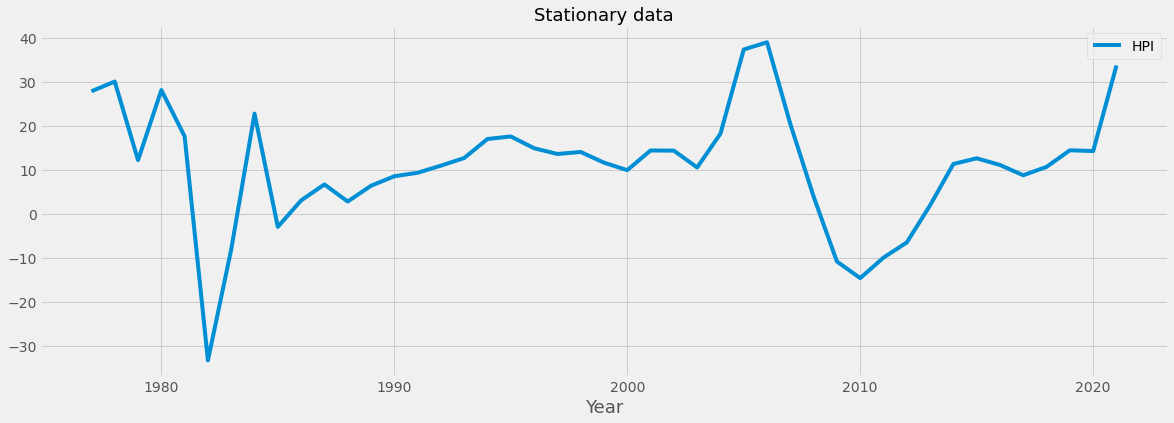

In [148]:
second_order_diff(West_Virginia)

In [149]:
pct(West_Virginia)

              State     HPI       pct
Year                                 
2002  West Virginia  244.03  0.023187
2003  West Virginia  249.01  0.020407
2004  West Virginia  262.21  0.053010
2005  West Virginia  286.32  0.091949
2006  West Virginia  301.16  0.051830
2007  West Virginia  306.70  0.018396
2008  West Virginia  305.05 -0.005380
2009  West Virginia  295.84 -0.030192
2010  West Virginia  290.41 -0.018355
2011  West Virginia  285.87 -0.015633
2012  West Virginia  283.88 -0.006961
2013  West Virginia  287.78  0.013738
2014  West Virginia  295.18  0.025714
2015  West Virginia  300.37  0.017582
2016  West Virginia  306.25  0.019576
2017  West Virginia  309.10  0.009306
2018  West Virginia  316.90  0.025235
2019  West Virginia  323.51  0.020858
2020  West Virginia  331.14  0.023585
2021  West Virginia  357.19  0.078668


## Wisconsin
2002 HPI: 373.80 (54.47 under national average)<br>
2021 HPI: 575.88 (161.78 under national average)<br> 
Median age by state: 40 <br>
between 95% - 99% 

Test Statistic                 -2.996708
p-value                         0.035203
#Lags Used                      1.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

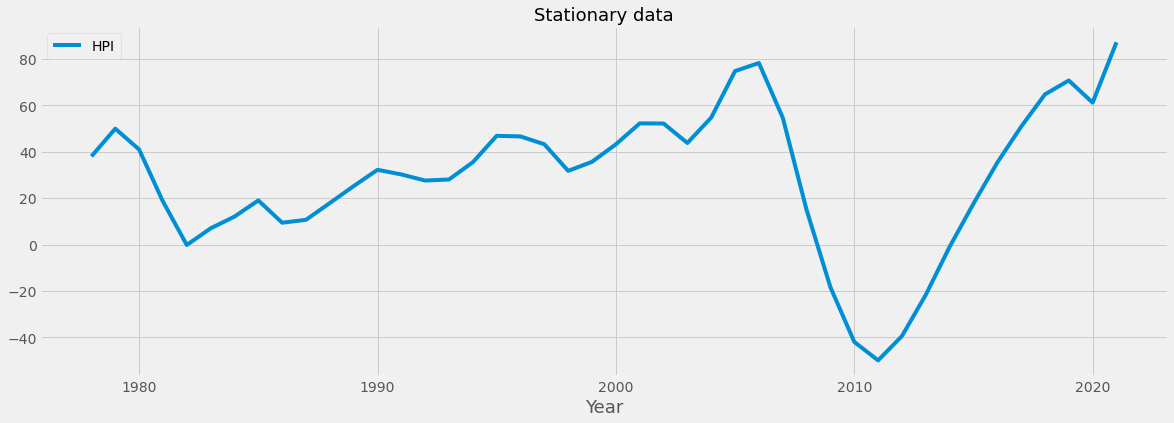

In [150]:
third_order_diff(Wisconsin)

In [151]:
pct(Wisconsin)

          State     HPI       pct
Year                             
2002  Wisconsin  373.80  0.038622
2003  Wisconsin  386.03  0.032718
2004  Wisconsin  414.62  0.074062
2005  Wisconsin  448.55  0.081834
2006  Wisconsin  464.25  0.035002
2007  Wisconsin  469.30  0.010878
2008  Wisconsin  463.48 -0.012401
2009  Wisconsin  445.87 -0.037995
2010  Wisconsin  427.34 -0.041559
2011  Wisconsin  413.54 -0.032293
2012  Wisconsin  406.41 -0.017241
2013  Wisconsin  405.66 -0.001845
2014  Wisconsin  412.53  0.016935
2015  Wisconsin  424.01  0.027828
2016  Wisconsin  440.97  0.039999
2017  Wisconsin  463.30  0.050638
2018  Wisconsin  488.72  0.054867
2019  Wisconsin  511.67  0.046959
2020  Wisconsin  524.45  0.024977
2021  Wisconsin  575.88  0.098065


## Wyoming 
2002 HPI: 335.37 (54.47 under national average)<br>
2021 HPI: 689.26 (161.78 under national average)<br> 
Median age by state: 40 <br>

In [152]:
pct(Wyoming)

        State     HPI       pct
Year                           
2002  Wyoming  335.37  0.055087
2003  Wyoming  351.84  0.049110
2004  Wyoming  382.47  0.087057
2005  Wyoming  426.44  0.114963
2006  Wyoming  478.29  0.121588
2007  Wyoming  522.02  0.091430
2008  Wyoming  532.79  0.020631
2009  Wyoming  519.94 -0.024118
2010  Wyoming  501.53 -0.035408
2011  Wyoming  493.65 -0.015712
2012  Wyoming  498.68  0.010189
2013  Wyoming  509.81  0.022319
2014  Wyoming  527.32  0.034346
2015  Wyoming  543.64  0.030949
2016  Wyoming  554.00  0.019057
2017  Wyoming  562.49  0.015325
2018  Wyoming  582.27  0.035165
2019  Wyoming  607.64  0.043571
2020  Wyoming  630.24  0.037193
2021  Wyoming  689.26  0.093647


## Table of newly added data

In [153]:
legal_df = {'State': ['National', 'Alaska', 'Arizona', 'California', 'Colorado', 
                      'Connecticut', 'District of Columbia', 'Illinois', 'Maine', 'Maryland', 
                      'Massachusetts', 'Michigan', 'Missouri', 'Montana', 
                      'New Jersey', 'New Mexico', 'New York', 'Nevada', 
                      'Oregon', 'Rhode Island', 'Vermont', 'Virginia', 
                      'Washington'],
            '2021 HPI': [ 737.66,525.17, 842.50, 1430.94, 1066.08,
                         663.63, 1583.64, 506.11, 777.13, 764.20,
                         1127.02, 568.85, 523.94, 900.57, 
                         856.28, 620.50, 823.52, 841.53,
                         1103.00, 933.02, 699.17, 710.99, 
                         1345.91], 
            'Median age': [np.nan, 35, 38, 37, 37, 41, 34, 38, 45, 39, 40, 40, 39,
                           40, 40, 38, 39, 38, 40, 40, 43, 38, 38]}

legal_df = pd.DataFrame(legal_df)
legal_df.head()

,State,2021 HPI,Median age
0,National,737.66,NaN
1,Alaska,525.17,35.0
2,Arizona,842.50,38.0
3,California,1430.94,37.0
4,Colorado,1066.08,37.0


In [154]:
# Get rid of first value in legal_df
legal_df_1 = legal_df.tail(-1)

In [155]:
# Find median age of those in legalized states / states that intend on legalizing
legal_df_1['Median age'].mean()

38.95454545454545

In [156]:
# Create new table of information for states that have not / do not show intention \
# of legalizing recreational cannabis 
ill_df = {'State': ['National', 'Alabama', 'Arkansas', 'Delaware', 'Florida', 
                    'Georgia', 'Hawaii', 'Indiana', 'Iowa', 
                    'Kentucky', 'Louisiana', 'Maryland', 'Minnesota',
                    'Mississippi', 'Nebraska', 'New Hampshire','North Carolina',
                    'North Dakota', 'Ohio', 
                    'Oklahoma', 'Pennsylvania', 'South Carolina', 
                    'South Dakota', 'Tennessee', 
                    'Texas', 'Utah', 'West Virginia', 'Wisconsin', 'Wyoming'], 
          '2021 HPI': [737.66, 453.77, 472.36, 621.23, 719.18, 526.50,
                       951.04, 523.49, 487.54, 553.66, 517.67,
                       764.20, 692.73, 381.90, 562.70, 842.52, 592.45,564.90, 
                       478.06, 492.28, 611.76,  556.93, 613.98, 601.36,
                       612.54, 1001.31, 357.19, 575.88, 689.26], 
          'Median age': [np.nan, 39, 38, 41, 42, 37, 39, 38, 38, 39, 37,
                         39, 38, 38, 37, 43, 39, 35, 40, 37, 41, 40, 37, 39, 
                         np.nan, 31, 43, 40, 38]}

ill_df = pd.DataFrame(ill_df)
ill_df.head()

,State,2021 HPI,Median age
0,National,737.66,NaN
1,Alabama,453.77,39.0
2,Arkansas,472.36,38.0
3,Delaware,621.23,41.0
4,Florida,719.18,42.0


In [157]:
# Drop National median age from illegal dataset
ill_df_1 = ill_df.tail(-1)

In [158]:
# Drop null values from dataset
ill_df_1 = ill_df_1.dropna()

In [159]:
# Find median age of illegal states
ill_df_1['Median age'].mean()

38.629629629629626

# Hypothesis testing #1: 

There is an observable effect on recreational cannabis legalization and raised HPI. We will try the first four states and separate them by region to measure if there is any effect.  

### Colorado: Q4 2012

In [160]:
# If we are correct, there should be an observable difference in either \
# 'HPI' or 'pct' for year 2013
pct_np(Colorado)
# Highlight of the three subsequent years after recreational cannabis \ 
# legalization 
Colorado.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2013 
                                        or x.name == 2014 
                                       or x.name == 2015)
                                    else '' for i in x], axis = 1)


,State,HPI,pct
Year,,,
2002,Colorado,520.970000,0.042044
2003,Colorado,525.590000,0.008868
2004,Colorado,541.160000,0.029624
2005,Colorado,567.940000,0.049486
2006,Colorado,587.150000,0.033824
2007,Colorado,591.850000,0.008005
2008,Colorado,585.320000,-0.011033
2009,Colorado,575.700000,-0.016435
2010,Colorado,552.140000,-0.040924


In [161]:
national_df.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2013 
                                        or x.name == 2014 
                                       or x.name == 2015)
                                    else '' for i in x], axis = 1)

,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
Year,,,,
2002,5.35,428.270000,150.910000,112.290000
2003,4.38,447.030000,157.520000,117.210000
2004,8.56,485.280000,171.000000,127.230000
2005,11.42,540.720000,190.530000,141.770000
2006,6.47,575.710000,202.860000,150.940000
2007,1.01,581.530000,204.910000,152.470000
2008,-4.35,556.210000,195.990000,145.830000
2009,-7.37,515.210000,181.540000,135.080000
2010,-4.99,489.500000,172.490000,128.340000


While again, we cannot make conclusions just based off of this information, it certainly seems that regionally, cannabis legalization had a marked effect on Colorado's HPI, potentially even beyond the three years originally hypothesized. 

### Washington: Q4 2012

In [162]:
# Washington state also legalized recreational cannabis use the same time \
# that Colorado did. We can reuse the same code from above
pct_np(Washington)
Washington.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2013 
                                        or x.name == 2014 
                                       or x.name == 2015)
                                    else '' for i in x], axis = 1)

,State,HPI,pct
Year,,,
2002,Washington,552.390000,0.037041
2003,Washington,567.140000,0.026702
2004,Washington,617.360000,0.088550
2005,Washington,717.870000,0.162806
2006,Washington,827.290000,0.152423
2007,Washington,882.320000,0.066518
2008,Washington,866.220000,-0.018247
2009,Washington,783.830000,-0.095114
2010,Washington,723.190000,-0.077364


So for the state of Washington it looks like we can conclude the same, the data suggests that cannabis legalization may have had a hand in elevated housing price index percentage for Washington. 

### Maine: Q4 2016

In [163]:
pct_np(Maine)
# Maine.tail(20).style.apply(lambda x: ['background: red'
#                                     if (x.name == 2017)
#                                      else '' for i in x], axis =1) 
                           
Maine.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2018
                                     or x.name ==2019)
                                     else '' for i in x], axis =1) 

,State,HPI,pct
Year,,,
2002,Maine,430.890000,0.083809
2003,Maine,459.010000,0.065260
2004,Maine,512.040000,0.115531
2005,Maine,568.990000,0.111222
2006,Maine,592.220000,0.040827
2007,Maine,597.990000,0.009743
2008,Maine,590.710000,-0.012174
2009,Maine,558.210000,-0.055019
2010,Maine,536.210000,-0.039412


In [164]:
# Show national HPI percentage data
national_df.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2017 
                                        or x.name == 2018 
                                       or x.name == 2019)
                                    else '' for i in x], axis = 1)

,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
Year,,,,
2002,5.35,428.270000,150.910000,112.290000
2003,4.38,447.030000,157.520000,117.210000
2004,8.56,485.280000,171.000000,127.230000
2005,11.42,540.720000,190.530000,141.770000
2006,6.47,575.710000,202.860000,150.940000
2007,1.01,581.530000,204.910000,152.470000
2008,-4.35,556.210000,195.990000,145.830000
2009,-7.37,515.210000,181.540000,135.080000
2010,-4.99,489.500000,172.490000,128.340000


Though it is by a small percentage, Maine also retains a higher HPI percentage change than the average in the United States for the 2nd and 3rd year after cannabis legalization. 

### Massachusetts Q4 2016

In [165]:
pct_np(Massachusetts)
Massachusetts.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2017 
                                       
                                       or x.name == 2019)
                                    else '' for i in x], axis = 1)

,State,HPI,pct
Year,,,
2002,Massachusetts,679.450000,0.105534
2003,Massachusetts,730.720000,0.075458
2004,Massachusetts,806.380000,0.103542
2005,Massachusetts,885.210000,0.097758
2006,Massachusetts,894.080000,0.010020
2007,Massachusetts,865.380000,-0.032100
2008,Massachusetts,823.830000,-0.048014
2009,Massachusetts,775.680000,-0.058447
2010,Massachusetts,757.250000,-0.023760


Massachusetts in 2015 and 2016 were below the national HPI percentage change, dipped below in 2018 as well, but did surpass in 2017 and 2019. 

Largely the data supports this idea that cannabis legalization has an upward trend in HPI, but generally speaking we can only move on average change of percentage if regionally there is not a state connecting that has legalized cannabis. 

# Hypothesis testing #2: 
Generally speaking, HPI percentage change in states that have legalized recreational cannabis use are higher than states that have not. We will look at the previous 10 recorded years (excluding COVID-19) and see which group of states has the higher average percentage. 

In [166]:
# Let's take the average of each percentage change per state which should \
# give us the average of all legal states
Alaska = Alaska.iloc[:-1, :]
pct_np(Alaska) 
Alaska_pct_mean = Alaska.tail(10)['pct'].mean()

Arizona = Arizona.iloc[:-1, :]
pct_np(Arizona)
Arizona_pct_mean = Arizona.tail(10)['pct'].mean()

California = California.iloc[:-1, :]
pct_np(California)
California_pct_mean = California.tail(10)['pct'].mean()

Colorado = Colorado.iloc[:-1, :]
pct_np(Colorado)
Colorado_pct_mean = Colorado.tail(10)['pct'].mean()

Connecticut = Connecticut.iloc[:-1, :]
pct_np(Connecticut)
Connecticut_pct_mean = Connecticut.tail(10)['pct'].mean()

District_of_Columbia = District_of_Columbia.iloc[:-1, :]
pct_np(District_of_Columbia)
District_of_Columbia_pct_mean = District_of_Columbia.tail(10)['pct'].mean()

Illinois = Illinois.iloc[:-1, :]
pct_np(Illinois)
Illinois_pct_mean = Illinois.tail(10)['pct'].mean()

Maine = Maine.iloc[:-1, :]
pct_np(Maine)
Maine_pct_mean = Maine.tail(10)['pct'].mean()

Maryland = Maryland.iloc[:-1, :]
pct_np(Maryland)
Maryland_pct_mean = Maryland.tail(10)['pct'].mean()

Massachusetts = Massachusetts.iloc[:-1, :]
pct_np(Massachusetts)
Massachusetts_pct_mean = Massachusetts.tail(10)['pct'].mean()

Michigan = Michigan.iloc[:-1, :]
pct_np(Michigan)
Michigan_pct_mean = Michigan.tail(10)['pct'].mean()

Missouri = Missouri.iloc[:-1, :]
pct_np(Missouri)
Missouri_pct_mean = Missouri.tail(10)['pct'].mean()

Montana = Montana.iloc[:-1, :]
pct_np(Montana)
Montana_pct_mean = Montana.tail(10)['pct'].mean()

New_Jersey = New_Jersey.iloc[:-1, :]
pct_np(New_Jersey)
New_Jersey_pct_mean = New_Jersey.tail(10)['pct'].mean()

New_Mexico = New_Mexico.iloc[:-1, :]
pct_np(New_Mexico)
New_Mexico_pct_mean = New_Mexico.tail(10)['pct'].mean()

New_York = New_York.iloc[:-1, :]
pct_np(New_York)
New_York_pct_mean = New_York.tail(10)['pct'].mean()

Nevada = Nevada.iloc[:-1, :]
pct_np(Nevada)
Nevada_pct_mean = Nevada.tail(10)['pct'].mean() 

Oregon = Oregon.iloc[:-1, :]
pct_np(Oregon)
Oregon_pct_mean = Oregon.tail(10)['pct'].mean()

Rhode_Island = Rhode_Island.iloc[:-1, :]
pct_np(Rhode_Island)
Rhode_Island_pct_mean = Rhode_Island.tail(10)['pct'].mean()

Vermont = Vermont.iloc[:-1, :]
pct_np(Vermont)
Vermont_pct_mean = Vermont.tail(10)['pct'].mean()

Virginia = Virginia.iloc[:-1, :]
pct_np(Virginia)
Virginia_pct_mean = Virginia.tail(10)['pct'].mean()

Washington = Washington.iloc[:-1, :]
pct_np(Washington)
Washington_pct_mean = Washington.tail(10)['pct'].mean()

In [167]:
# Take the average of each percentage change per state in all of the \
# non legal states

Alabama = Alabama.iloc[:-1, :]
pct_np(Alabama)
Alabama_pct_mean = Alabama.tail(10)['pct'].mean()

Arkansas = Arkansas.iloc[:-1, :]
pct_np(Arkansas)
Arkansas_pct_mean = Arkansas.tail(10)['pct'].mean()

Delaware_1 = Delaware.iloc[:-1, :]
pct_np(Delaware_1)
Delaware_pct_mean = Delaware.tail(10)['pct'].mean()

Florida = Florida.iloc[:-1, :]
pct_np(Florida)
Florida_pct_mean = Florida.tail(10)['pct'].mean()

Georgia = Georgia.iloc[:-1, :]
pct_np(Georgia)
Georgia_pct_mean = Georgia.tail(10)['pct'].mean()

Hawaii = Hawaii.iloc[:-1, :]
pct_np(Hawaii)
Hawaii_pct_mean = Hawaii.tail(10)['pct'].mean()

Indiana = Indiana.iloc[:-1, :]
pct_np(Indiana)
Indiana_pct_mean = Indiana.tail(10)['pct'].mean()

Iowa = Iowa.iloc[:-1, :]
pct_np(Iowa)
Iowa_pct_mean = Iowa.tail(10)['pct'].mean()

Kentucky = Kentucky.iloc[:-1, :]
pct_np(Kentucky)
Kentucky_pct_mean = Kentucky.tail(10)['pct'].mean()

Louisiana = Louisiana.iloc[:-1, :]
pct_np(Louisiana)
Louisiana_pct_mean = Louisiana.tail(10)['pct'].mean()

Maryland = Maryland.iloc[:-1, :]
pct_np(Maryland)
Maryland_pct_mean = Maryland.tail(10)['pct'].mean()

Minnesota = Minnesota.iloc[:-1, :]
pct_np(Minnesota)
Minnesota_pct_mean = Minnesota.tail(10)['pct'].mean()

Mississippi = Mississippi.iloc[:-1, :]
pct_np(Mississippi)
Mississippi_pct_mean = Mississippi.tail(10)['pct'].mean()

Nebraska = Nebraska.iloc[:-1, :]
pct_np(Nebraska)
Nebraska_pct_mean = Nebraska.tail(10)['pct'].mean()

New_Hampshire = New_Hampshire.iloc[:-1, :]
pct_np(New_Hampshire)
New_Hampshire_pct_mean = New_Hampshire.tail(10)['pct'].mean()

North_Carolina = North_Carolina.iloc[:-1, :]
pct_np(North_Carolina)
North_Carolina_pct_mean = North_Carolina.tail(10)['pct'].mean()

North_Dakota = North_Dakota.iloc[:-1, :]
pct_np(North_Dakota)
North_Dakota_pct_mean = North_Dakota.tail(10)['pct'].mean()

Ohio = Ohio.iloc[:-1, :]
pct_np(Ohio)
Ohio_pct_mean = Ohio.tail(10)['pct'].mean()

Oklahoma = Oklahoma.iloc[:-1, :]
pct_np(Oklahoma)
Oklahoma_pct_mean = Oklahoma.tail(10)['pct'].mean()

Pennsylvania = Pennsylvania.iloc[:-1, :]
pct_np(Pennsylvania)
Pennsylvania_pct_mean = Pennsylvania.tail(10)['pct'].mean()

South_Carolina = South_Carolina.iloc[:-1, :]
pct_np(South_Carolina)
South_Carolina_pct_mean = South_Carolina.tail(10)['pct'].mean()

South_Dakota = South_Dakota.iloc[:-1, :]
pct_np(South_Dakota)
South_Dakota_pct_mean = South_Dakota.tail(10)['pct'].mean()

Tennessee = Tennessee.iloc[:-1, :]
pct_np(Tennessee)
Tennessee_pct_mean = Tennessee.tail(10)['pct'].mean()

Texas = Texas.iloc[:-1, :]
pct_np(Texas)
Texas_pct_mean = Texas.tail(10)['pct'].mean()

Utah = Utah.iloc[:-1, :]
pct_np(Utah)
Utah_pct_mean = Utah.tail(10)['pct'].mean()

West_Virginia = West_Virginia.iloc[:-1, :]
pct_np(West_Virginia)
West_Virginia_pct_mean = West_Virginia.tail(10)['pct'].mean()

Wisconsin = Wisconsin.iloc[:-1, :]
pct_np(Wisconsin)
Wisconsin_pct_mean = Wisconsin.tail(10)['pct'].mean()

Wyoming = Wyoming.iloc[:-1, :]
pct_np(Wyoming)
Wyoming_pct_mean = Wyoming.tail(10)['pct'].mean()

In [168]:
# The above is not quite accurate as we do not have data on all of the \
# states when legality has happened. Let's create a new list
legal_pct_mean = (Alaska_pct_mean + California_pct_mean + Colorado_pct_mean
                  + Illinois_pct_mean + Arizona_pct_mean
                  + Maine_pct_mean + Massachusetts_pct_mean 
                  + Michigan_pct_mean + Nevada_pct_mean
                  + Oregon_pct_mean + Washington_pct_mean)/9

legal_pct_mean

0.05067836023033905

In [169]:
national_df = national_df.iloc[:-1, :]

In [170]:
# Get our national average percentage change over the last 20 years
national_per = national_df.tail(10)['Annual Change (%)'].astype('float')
national_per.mean()

3.128

In [171]:
# Get our state HPI percentage change average from the states that have not \
# legalized recreational cannabis use
illegal_pct_mean = (Alabama_pct_mean + Arkansas_pct_mean + Delaware_pct_mean +
Florida_pct_mean + Georgia_pct_mean + Hawaii_pct_mean + Indiana_pct_mean +
Iowa_pct_mean + Kentucky_pct_mean + Louisiana_pct_mean + Maryland_pct_mean +
Minnesota_pct_mean + Mississippi_pct_mean + Nebraska_pct_mean +
New_Hampshire_pct_mean + North_Carolina_pct_mean + North_Dakota_pct_mean +
Ohio_pct_mean + Oklahoma_pct_mean + Pennsylvania_pct_mean + South_Carolina_pct_mean +
South_Dakota_pct_mean + Tennessee_pct_mean + Texas_pct_mean + Utah_pct_mean +
West_Virginia_pct_mean + Wisconsin_pct_mean + Wyoming_pct_mean)/ 28

illegal_pct_mean

0.02736599394242902

In [172]:
# Get our state HPI percentage change average from the states that we do \
# not have HPI percentage increase data for due to not having legalized \ 
# recreational cannabis use or due to not having data for legalization \
# based on the year after's HPI percentage change data
illegal_or_no_pct_mean = (Alabama_pct_mean + Arkansas_pct_mean + Delaware_pct_mean +
Florida_pct_mean + Georgia_pct_mean + Hawaii_pct_mean + Indiana_pct_mean +
Iowa_pct_mean + Kentucky_pct_mean + Louisiana_pct_mean + Maryland_pct_mean +
Minnesota_pct_mean + Mississippi_pct_mean + Nebraska_pct_mean +
New_Hampshire_pct_mean + North_Carolina_pct_mean + North_Dakota_pct_mean +
Ohio_pct_mean + Oklahoma_pct_mean + Pennsylvania_pct_mean + South_Carolina_pct_mean +
South_Dakota_pct_mean + Tennessee_pct_mean + Texas_pct_mean + Utah_pct_mean +
West_Virginia_pct_mean + Wisconsin_pct_mean + Wyoming_pct_mean
+ Connecticut_pct_mean + Maryland_pct_mean + Missouri_pct_mean +
Montana_pct_mean + New_Jersey_pct_mean + New_Mexico_pct_mean +
New_York_pct_mean + Rhode_Island_pct_mean + Vermont_pct_mean +
Virginia_pct_mean)/ 38

illegal_or_no_pct_mean

0.024752868711349317

Yes, we can conclusively say that HPI percentage change in the past 10 years is higher than in states that did not legalize recreational cannabis use during the recorded times in our dataset. 

## Business suggestion #1: 

There is an implied change in our dataset regarding increased HPI percentage change and cannabis legalization. It is our suggestion to consider investing inside of that space (a state that has legalized recreational cannabis use) the year legislation is passed and to consider selling within 3 - 4 years of acquiring a property. 

* The earliest adopters of legalized recreational cannabis use experienced up to 4 years of HPI percentage change increase that was measured above the national average; _this could be due to other external factors._ <br>
* This data was taken from the first four states to legalize recreational use of cannabis in the following regions:<br><br>
    * West Coast: Washington 2012 - 2016 = 2.84% above national average 2012 - 2016<br><br>
    * Mountainous West: Colorado 2012 - 2016 = 3.72% above national average  2012 - 2016<br><br>
    * East Coast: Maine 2016 - 2020 = 0.57% above national average 2016 - 2020 <br><br>
    * East Coast: Massachusetts 2016 - 2020 = .06% above national average 2016-2020

## Business suggestion #2: 

As of 4/23/23 recreational cannabis use is legal has become legal in Delaware. Our suggestion is to purchase properties, _now_. <br><br>

<img src="photos/delaware.webp"  /><br><br>
<center>Delaware Presidential Election Voting History<br>
270towin.com (2020)</center><br><br>




### Delaware

In [173]:
# Preview Delaware state HPI information
Delaware.tail()

,State,HPI,pct
Year,,,
2017,Delaware,506.62,0.020506
2018,Delaware,526.62,0.039477
2019,Delaware,543.72,0.032471
2020,Delaware,561.55,0.032793
2021,Delaware,621.23,0.106277


In [174]:
# We will not need pct, let's create a new variable 
Del = Delaware.drop(columns = 'pct', axis = 1)
Del.tail()

,State,HPI
Year,,
2017,Delaware,506.62
2018,Delaware,526.62
2019,Delaware,543.72
2020,Delaware,561.55
2021,Delaware,621.23


Test Statistic                 -4.838370
p-value                         0.000046
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

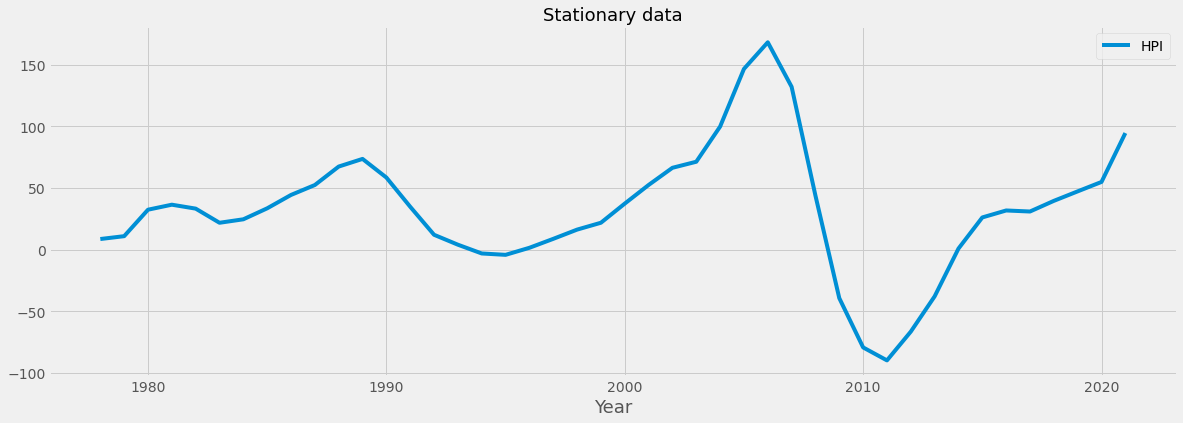

In [175]:
# Call on our stationary data for Delaware 
Del_stationary = third_order_diff(Del)
Del_stationary

### Train/Test Split on Delaware

In [176]:
# Creata arma variable and drop column 'State'
Del_arma = Del.drop(columns = 'State', axis = 1)

In [177]:
# Replicate stationary data 
Del_arma = Del_arma.diff(periods = 3)

In [178]:
# Create cutoff variable for train/test split
cutoff = round(Del_arma.shape[0] * 0.75)
cutoff

35

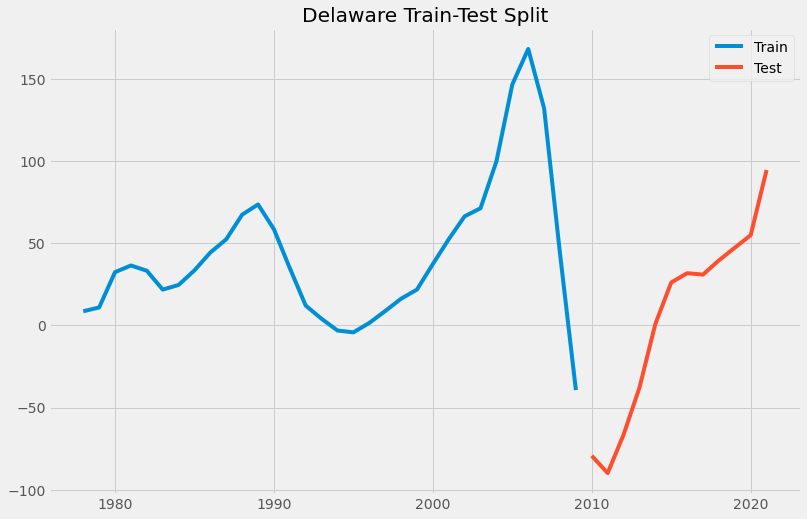

In [179]:
# Plot our new split plot 
train = Del_arma[:cutoff]
test = Del_arma[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Delaware Train-Test Split')
plt.legend();

### Plot ACF on Delaware data

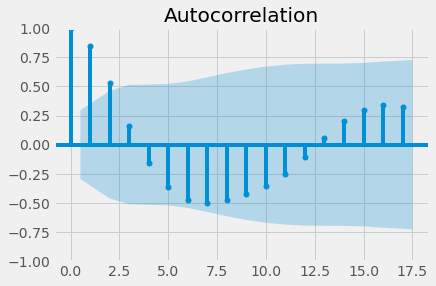

In [180]:
plot_acf(Del_arma.dropna());

### Plot PACF on Delaware data 

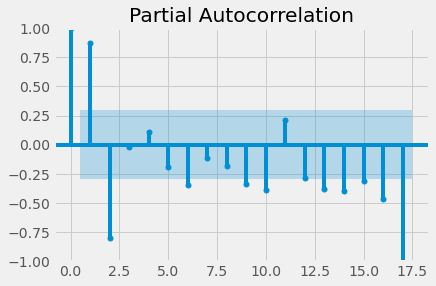

In [181]:
plot_pacf(Del_arma.dropna());

### Arma model on Delaware dataset

In [182]:
arma_Del = ARIMA(train, order = (3,0,2)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [183]:
print(arma_Del.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   35
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -121.949
Date:                Tue, 25 Apr 2023   AIC                            257.897
Time:                        18:40:30   BIC                            268.785
Sample:                             0   HQIC                           261.656
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.5046     12.992      3.041      0.002      14.041      64.969
ar.L1          0.8064      0.192      4.191      0.000       0.429       1.183
ar.L2          0.1269      0.349      0.364      0.7

In [184]:
print(arma_Del.aic)

257.89716869659594


### Testing on Delaware dataset

In [185]:
arma_Del_test = ARIMA (test, order = (3,0,2)).fit() 

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [186]:
print(arma_Del_test.aic)

116.80543876731248


In [187]:
train = train.fillna(method = 'backfill')

In [188]:
y_hat = y_hat [3:35]
y_hat

Year
1978     35.719686
1979     37.227054
1980     56.531203
1981     42.947589
1982     36.489071
1983     11.984702
1984     18.745843
1985     24.563485
1986     34.750379
1987     34.043126
1988     38.380398
1989     58.214273
1990     58.343759
1991     26.062361
1992     16.661717
1993      6.706947
1994      5.261275
1995     18.458614
1996     29.311754
1997     31.340499
1998     36.411073
1999     34.070688
2000     44.578868
2001     76.301662
2002     68.531952
2003     63.487558
2004     52.905130
2005     99.227243
2006    144.667856
2007     99.457139
2008     25.123748
2009    -51.373520
Name: predicted_mean, dtype: float64

In [189]:
# RMSE score for Delaware test prediction
y_hat = arma_Del.predict(typ = 'levels')
np.sqrt(mean_squared_error(train, y_hat))

14.111478881381503

In [190]:
# Create testing environment for Delaware
Del_national_test = ARIMA(test, order = (3,0,2)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Predict into the future on Delaware data 

In [191]:
# predict our forecast for the next 3 years 
forecast = arma_Del.forecast(18)
forecast

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


35    -80.432376
36    -65.012048
37    -19.665130
38     39.833398
39     85.685058
40    107.030942
41     99.649851
42     72.969372
43     39.606610
44     13.090109
45      1.111347
46      5.140253
47     20.423036
48     39.381279
49     54.549147
50     61.374429
51     59.112553
52     50.401607
Name: predicted_mean, dtype: float64

In [192]:
# We ran into this issue with our national data earlier \ 
# We can likely fix it the same way 
forecast.index.tolist()


[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]

In [193]:
test.index.tolist()

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [194]:
forecast = pd.DataFrame(forecast)

In [195]:
forecast.tail()

,predicted_mean
48,39.381279
49,54.549147
50,61.374429
51,59.112553
52,50.401607


In [196]:
list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
        2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

forecast['Year'] = list

forecast

,predicted_mean,Year
35,-80.432376,2010
36,-65.012048,2011
37,-19.665130,2012
38,39.833398,2013
39,85.685058,2014
40,107.030942,2015
41,99.649851,2016
42,72.969372,2017
43,39.606610,2018
44,13.090109,2019


In [197]:
forecast = forecast.set_index('Year')

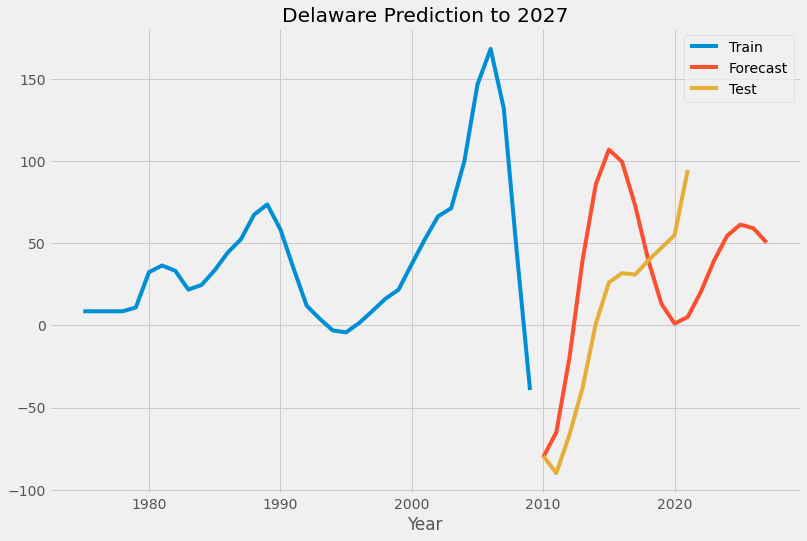

In [198]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('Delaware Prediction to 2027')
ax.set_xlabel('Year')
ax.legend();

While we cannot make any assumptions regarding HPI percentage change or even HPI, we can say that our forecasted prediction and test set report a positive change over the next three years. Our model predicts that in 2022 (not shown in data) the HPI will go up 20.42 points, in 2023 39.38, and in 2024 54.55. Our model has a standard deviation of 14.11. In the year 2025 however it appears that there will be a potential HPI recession. 

## Delaware Legalizaiton: Successful

According to 'Millions in Revenue Anticipated from Legalizing Marijuana in Delaware', orignally published on January 25, 2021 by Delaware State Auditor Kathy McGuiness, RPh, CFE link: https://auditor.delaware.gov/wp-content/uploads/sites/40/2021/01/Marijuana-Special-Report-FInal-Report-2021.pdf<br> <br>


In short: Delaware is likely to see a 215 million dollar cannabis industry based on its adult population of 792,119 (2021), an approximated 13 percent use rate in the adult population, with an estimated annual user spending of $2080 


With legalization of recreational cannabis use having been successful this past weekend in Delaware and an understanding that the housing price index (HPI) historically ticks upward during times of legalization, our ultimate suggestion is to invest in Delaware properties, now and consider selling at peak within the next 3 - 4 years.



## Business Suggestion #3: 

It would seem that political alignment of a state has something to do with legalization of recreational cannabis use; the following states have either historically or recently voted for a democratic presidential candidate and have bills actively or plans to draft bills for legalization of recreational cannabis use in the near future. Consider investing in these states, next. 

States to watch: <br>

- Minnesota: house is set to vote on a bill drafted on 4/20/23 https://www.cbsnews.com/minnesota/news/420-legalized-cannabis-vote-minnesota-house/<br><br>

- Wisconsin: state GOP lawmakers set to work on cannabis legalization https://apnews.com/article/wisconsin-medical-marijuana-legalization-republicans-92a5764d72a54914ecee54b37d6e8d5b<br><br>

- Georgia: 2020 was the first year since 1992 that Georgia has voted democrat, there is a growing movement for recreational cannabis legalization via https://norml.org/georgia-marijuana-legalization-effort/ 

# Conclusion

In conclusion, the data suggest that there is in fact a relationship between states that have legalized recreational cannabis and elevated HPI. 
<br><br>
It is our suggestion to purchase property in states that have legalized recreational cannabis in the same year that it was announced. 
<br><br>
Also for consideration, states that are considered ‘blue’ are also the most likely to also be considered a ‘green’ state.  
